### Load accident data corresponding to far_part 121

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import random

import collections
import matplotlib.pyplot as plt
%matplotlib inline

## New - With the implementation of eADMS in 2006, the "Events_Sequence" table will replace the "Occurrences"
## table and the "Findings" table will replace the "Seq_of_events" table.

Events_Sequence = pd.read_csv('Events_Sequence.txt', sep = '\t')  ## eADMS coding for accidents after 2006
aircraft = pd.read_excel('aircraft.xlsx')
occurrences = pd.read_csv('Occurrences.txt', sep = ',')
seq_of_events_ = pd.read_csv('seq_of_events.txt', sep = '\t') ## pre eADMS coding for accidents before 2006

narratives = pd.read_excel('narratives.xlsx')
metaData = pd.read_excel('metaData.xlsx')
events = pd.read_excel('events.xlsx')
engines = pd.read_excel('engines.xlsx')
injury = pd.read_excel('injury.xlsx')
findings = pd.read_excel('findings.xlsx')

In [2]:
Events_Sequence[Events_Sequence['ev_id'] == '20001208X08803']

,ev_id,Aircraft_Key,Occurrence_No,Occurrence_Code,Occurrence_Description,phase_no,eventsoe_no,Defining_ev,lchg_date,lchg_userid
0,20001208X08803,1,3,400240,Enroute - Loss of control in flight,400,240,1,5/13/2019 14:50:49,bowl


In [3]:
print ('The values of cause_factor are', set(seq_of_events_['Cause_Factor'].values))

The values of cause_factor are {nan, 'c', ' ', 'X', 'F', 'C', 'D', '2', '1', 'f'}


#### Process the values of cause_factor

In [4]:
seq_of_events_[seq_of_events_['Cause_Factor'] == 'X']

,ev_id,Aircraft_Key,Occurrence_No,seq_event_no,group_code,Subj_Code,Cause_Factor,Modifier_Code,Person_Code,lchg_date,lchg_userid
58266,20001213X34629,1,2,1,2,24500,X,3131,4000.0,12/13/2000 16:58:22,dbo
76321,20001213X31660,1,1,2,2,24539,X,3131,4000.0,12/13/2000 14:40:01,dbo
103128,20001214X37504,1,4,1,1,20200,X,2511,0.0,12/14/2000 13:05:05,dbo
168019,20001213X33849,1,2,1,2,24551,X,3113,4000.0,12/13/2000 16:13:55,dbo
197452,20001214X39233,1,2,3,1,20000,X,2207,0.0,12/14/2000 14:24:49,dbo
239753,20001211X15049,1,1,2,2,24551,X,3113,4000.0,12/11/2000 15:07:06,dbo


In [5]:
seq_of_events = seq_of_events_.dropna(axis = 0, subset =['Cause_Factor']).copy()

In [6]:
seq_of_events.loc[seq_of_events.Cause_Factor == '1','Cause_Factor'] = 'C'
seq_of_events.loc[seq_of_events.Cause_Factor == '2','Cause_Factor'] = 'F'
seq_of_events.loc[seq_of_events.Cause_Factor == 'c','Cause_Factor'] = 'C'
seq_of_events.loc[seq_of_events.Cause_Factor == 'f','Cause_Factor'] = 'F'
seq_of_events.loc[seq_of_events.Cause_Factor == 'D','Cause_Factor'] = 'C'
seq_of_events.loc[seq_of_events.Cause_Factor == 'X','Cause_Factor'] = 'F'

indexes = seq_of_events[seq_of_events['Cause_Factor'] == ' '].index
seq_of_events.drop(indexes, inplace = True)

In [7]:
set(seq_of_events['Cause_Factor'].values)

{'C', 'F'}

In [8]:
metaData['code_iaids'] = metaData['code_iaids'].astype(str)
indices = seq_of_events[seq_of_events['Subj_Code'] == 0].index
seq_of_events.drop(indices, inplace = True)

In [9]:
indices

Int64Index([133286, 163656, 163657, 246474], dtype='int64')

### Accident Statistical Summary

#### Total number of accidents in far_part 121

In [10]:
ev_ID = aircraft['ev_id'].values.tolist()

## Remove duplicated event IDs
ev_ID = list(set(ev_ID))

print ('There are {} accidents in NTSB database with far_part equal to 121'.format(len(ev_ID)))
print ('The data ranges from {} to {}'.format(min(events['ev_year'].values), max(events['ev_year'].values)))

There are 2243 accidents in NTSB database with far_part equal to 121
The data ranges from 1982 to 2019


#### Basic statistics

In [11]:
events_part = events[events['ev_id'].isin(ev_ID)]

In [12]:
events_part['ev_highest_injury'].fillna('Not Reported', inplace = True)

In [13]:
from itertools import product
combs = pd.DataFrame(list(product(set(events_part['ev_year'].values), set(events_part['ev_highest_injury'].values))), 
                     columns=['ev_year', 'ev_highest_injury'])

In [14]:
g = events_part.groupby(['ev_year','ev_highest_injury']).size().to_frame('count').reset_index()
g

,ev_year,ev_highest_injury,count
0,1982,FATL,5
1,1982,MINR,5
2,1982,NONE,27
3,1982,SERS,8
4,1983,FATL,4
...,...,...,...
167,2019,FATL,1
168,2019,MINR,2
169,2019,Not Reported,4
170,2019,SERS,2


In [15]:
result = g.merge(combs, how = 'right').fillna(0)

In [16]:
FATL_res = result[result['ev_highest_injury'] == 'FATL'].sort_values(by=['ev_year'])
MINR_res = result[result['ev_highest_injury'] == 'MINR'].sort_values(by=['ev_year'])
NONE_res = result[result['ev_highest_injury'] == 'NONE'].sort_values(by=['ev_year'])
SERS_res = result[result['ev_highest_injury'] == 'SERS'].sort_values(by=['ev_year'])
UNKN_res = result[result['ev_highest_injury'] == 'UNKN'].sort_values(by=['ev_year'])
No_Report_res = result[result['ev_highest_injury'] == 'Not Reported'].sort_values(by=['ev_year'])

In [17]:
aircraft['damage'].fillna('Not Reported', inplace = True)

In [18]:
aircraft['ev_year'] = aircraft['ev_id'].astype(str).str[:4]

from itertools import product
aicrftCombs = pd.DataFrame(list(product(set(aircraft['ev_year'].values), set(aircraft['damage'].values))), 
                     columns=['ev_year', 'damage'])

aircraftDamage = aircraft['damage'].groupby([aircraft['ev_year'], aircraft['damage']]).size().to_frame('count').reset_index()

aircraftResult = aircraftDamage.merge(aicrftCombs, how = 'right').fillna(0)

In [19]:
aircraftResult[aircraftResult['ev_year'] == '2015']

,ev_year,damage,count
58,2015,MINR,6.0
59,2015,NONE,21.0
60,2015,Not Reported,1.0
61,2015,SUBS,7.0
89,2015,UNK,0.0
90,2015,DEST,0.0


In [20]:
aircraftResult.loc[aircraftResult['ev_year'] == '2000']

,ev_year,damage,count
0,2000,DEST,60.0
1,2000,MINR,472.0
2,2000,NONE,532.0
3,2000,SUBS,246.0
4,2000,UNK,1.0
88,2000,Not Reported,0.0


In [21]:
aircraftResult

,ev_year,damage,count
0,2000,DEST,60.0
1,2000,MINR,472.0
2,2000,NONE,532.0
3,2000,SUBS,246.0
4,2000,UNK,1.0
...,...,...,...
115,2008,UNK,0.0
116,2008,Not Reported,0.0
117,2012,UNK,0.0
118,2012,DEST,0.0


In [22]:
idx = aircraftResult.index[aircraftResult['ev_year'] == '2000']

aircraftResult.drop(list(idx), inplace = True)

###### Aircraft damage VS year

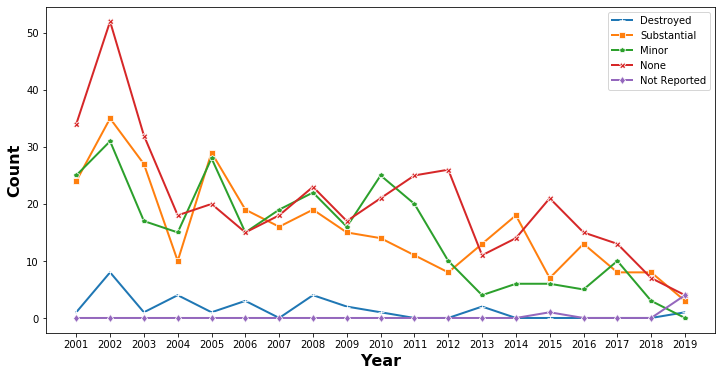

In [23]:
aircraft_DEST_res = aircraftResult[aircraftResult['damage'] == 'DEST'].sort_values(by=['ev_year'])
aircraft_SERS_res = aircraftResult[aircraftResult['damage'] == 'SUBS'].sort_values(by=['ev_year'])
aircraft_MINR_res = aircraftResult[aircraftResult['damage'] == 'MINR'].sort_values(by=['ev_year'])
aircraft_NONE_res = aircraftResult[aircraftResult['damage'] == 'NONE'].sort_values(by=['ev_year'])
aircraft_UNKN_res = aircraftResult[aircraftResult['damage'] == 'Not Reported'].sort_values(by=['ev_year'])

fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(aircraft_DEST_res['ev_year'].values, aircraft_DEST_res['count'].values, marker = '+', lw = 2)
sns.lineplot(aircraft_SERS_res['ev_year'].values, aircraft_SERS_res['count'].values, marker = 's', lw = 2)
sns.lineplot(aircraft_MINR_res['ev_year'].values, aircraft_MINR_res['count'].values, marker = 'p', lw = 2)
sns.lineplot(aircraft_NONE_res['ev_year'].values, aircraft_NONE_res['count'].values, marker = 'X', lw = 2)
sns.lineplot(aircraft_UNKN_res['ev_year'].values, aircraft_UNKN_res['count'].values, marker = 'd', lw = 2)
plt.legend(['Destroyed', 'Substantial', 'Minor', 'None', 'Not Reported'])
plt.xlabel('Year', fontsize = 16, fontweight = 'bold')
plt.ylabel('Count', fontsize = 16, fontweight = 'bold')
plt.savefig('damage_vs_year.pdf')

##### Injury VS year

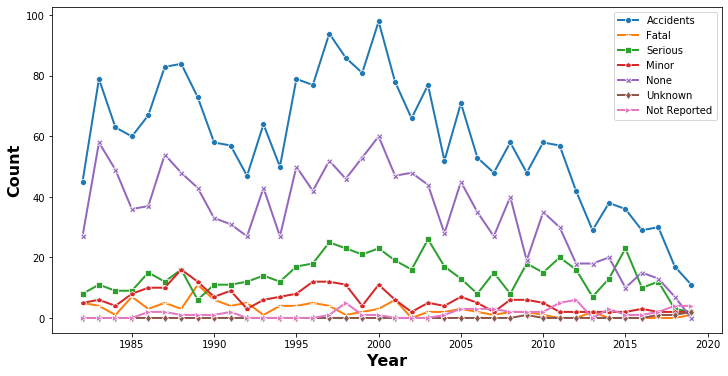

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))

noEventsbyYear = events_part['ev_year'].groupby(events_part['ev_year'].rename('year')).agg({'count'})
sns.lineplot(No_Report_res['ev_year'].values, noEventsbyYear['count'], marker = 'o', lw = 2)

sns.lineplot(FATL_res['ev_year'].values, FATL_res['count'].values, marker = '+', lw = 2)
sns.lineplot(SERS_res['ev_year'].values, SERS_res['count'].values, marker = 's', lw = 2)
sns.lineplot(MINR_res['ev_year'].values, MINR_res['count'].values, marker = 'p', lw = 2)
sns.lineplot(NONE_res['ev_year'].values, NONE_res['count'].values, marker = 'X', lw = 2)
sns.lineplot(UNKN_res['ev_year'].values, UNKN_res['count'].values, marker = 'd', lw = 2)
sns.lineplot(No_Report_res['ev_year'].values, No_Report_res['count'].values, marker = '>', lw = 2)

plt.xlabel('Year', fontsize = 16, fontweight = 'bold')
plt.ylabel('Count', fontsize = 16, fontweight = 'bold')
plt.legend(['Accidents', 'Fatal', 'Serious', 'Minor', 'None', 'Unknown', 'Not Reported'])
plt.savefig('injury_vs_year.pdf')

#### Accident vs Aircraft Manufactuer

In [25]:
acft_make_counter = collections.Counter(aircraft['acft_make'].str.title())
acft_make_counter_plot = {k: v for k, v in acft_make_counter.items() if v > 5}

Text(0, 0.5, 'No of accidents')

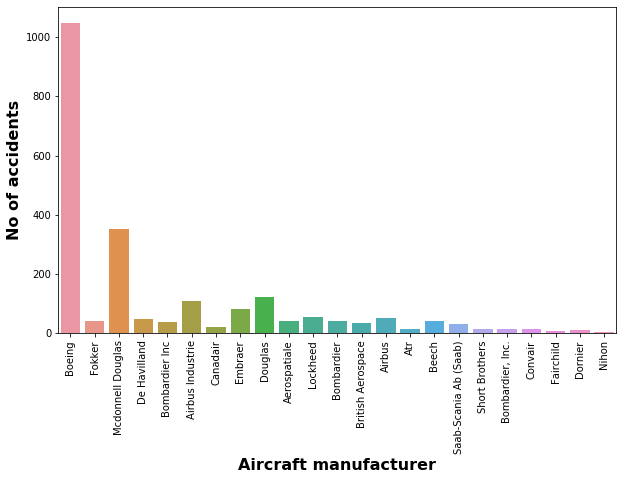

In [26]:
plt.figure(figsize = (10, 6))
sns.barplot(list(acft_make_counter_plot.keys()), list(acft_make_counter_plot.values()))
plt.xticks(rotation=90)
plt.xlabel('Aircraft manufacturer', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of accidents', fontsize = 16, fontweight = 'bold')

#### Accident vs Event Type

In [27]:
ev_type_counter = collections.Counter(events['ev_type'].fillna('Unknown'))
ev_type_keys = ['Accident','Incident','Unknown']

Text(0, 0.5, 'No of events')

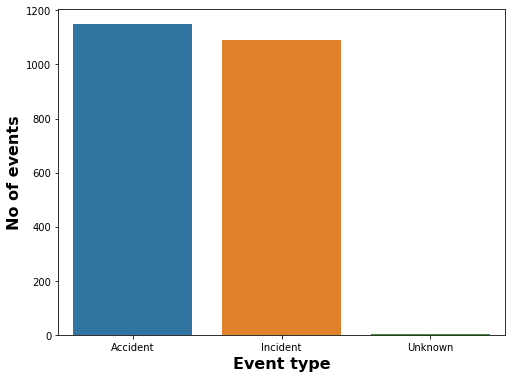

In [28]:
plt.figure(figsize = (8, 6))
sns.barplot(ev_type_keys, list(ev_type_counter.values()))
plt.xlabel('Event type', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Year

Text(0, 0.5, 'No of events')

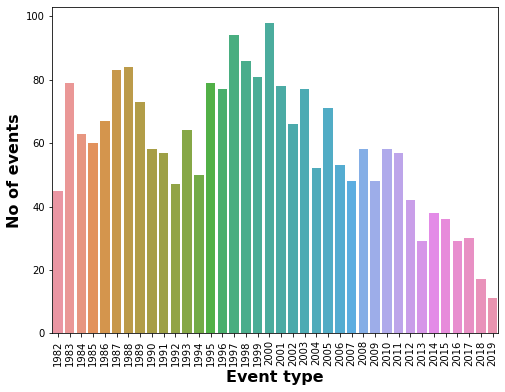

In [29]:
ev_year_counter = collections.Counter(events['ev_year'])

plt.figure(figsize = (8, 6))
sns.barplot(list(ev_year_counter.keys()), list(ev_year_counter.values()))
plt.xticks(rotation=90)
plt.xlabel('Event type', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs State

Text(0, 0.5, 'No of events')

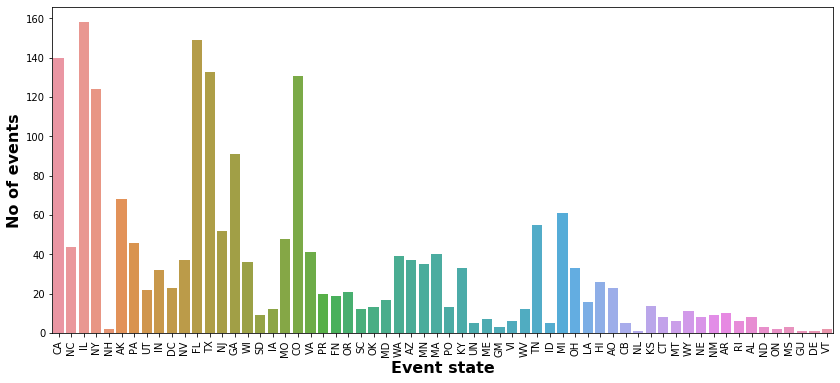

In [30]:
ev_state_counter = collections.Counter(events['ev_state'])

plt.figure(figsize = (14, 6))
sns.barplot(list(ev_state_counter.keys()), list(ev_state_counter.values()))
plt.xticks(rotation=90)
plt.xlabel('Event state', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Wind Gusting

In [31]:
gust_ind_counter = collections.Counter(events['gust_ind'].fillna('Not Reported'))
gust_ind_keys = ['Not Gusting', 'Gusting', 'Unknown', 'Not Reported']

Text(0, 0.5, 'No of events')

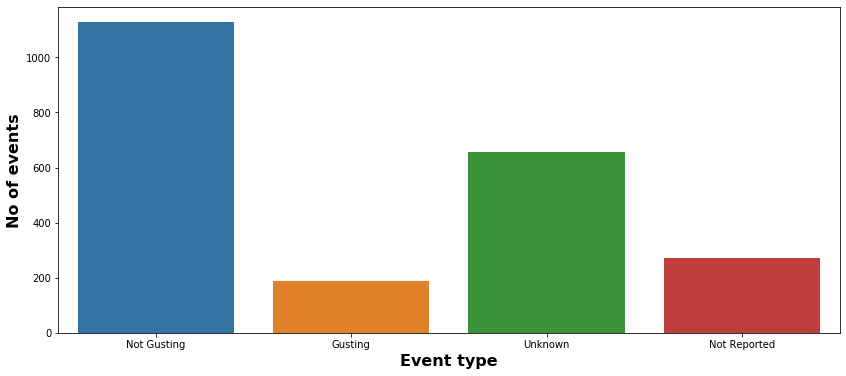

In [32]:
plt.figure(figsize = (14, 6))
sns.barplot(gust_ind_keys, list(gust_ind_counter.values()))
plt.xlabel('Event type', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Airport Elevation

In [33]:
elevation = events['apt_elev'].values
elevation = elevation[~np.isnan(elevation)]

Text(0, 0.5, 'Probability')

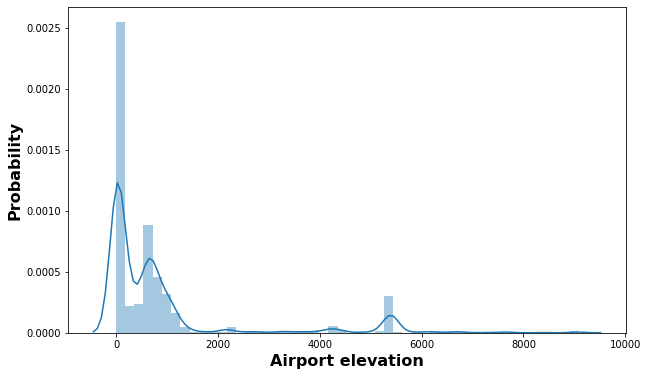

In [34]:
plt.figure(figsize = (10, 6))
sns.distplot(elevation)
plt.xlabel('Airport elevation', fontsize = 16, fontweight = 'bold')
plt.ylabel('Probability', fontsize = 16, fontweight = 'bold')

#### Accident vs Highest Injury

Text(0, 0.5, 'No of events')

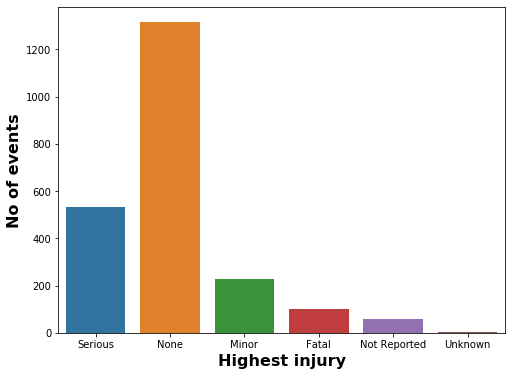

In [35]:
ev_highest_injury_counter = collections.Counter(events['ev_highest_injury'].fillna('Not Reported'))
ev_highest_injury_keys = ['Serious', 'None', 'Minor', 'Fatal', 'Not Reported', 'Unknown']

plt.figure(figsize = (8, 6))
sns.barplot(ev_highest_injury_keys, list(ev_highest_injury_counter.values()))
plt.xlabel('Highest injury', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Aircraft Damage

In [36]:
ev_aircraft_damage_counter = collections.Counter(aircraft['damage'].fillna('Not Reported'))
ev_aircraft_damage_counter

Counter({'NONE': 918,
         'SUBS': 543,
         'MINR': 749,
         'DEST': 88,
         'Not Reported': 5,
         'UNK': 5})

#### Accident vs Location

Text(0, 0.5, 'No of events')

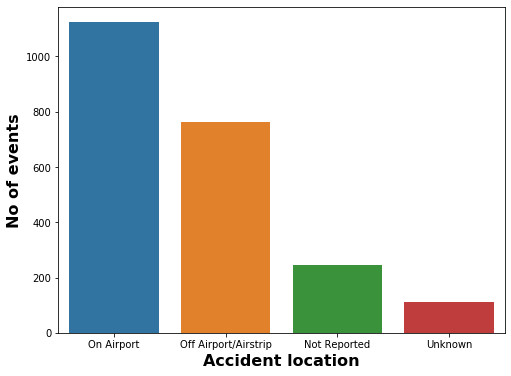

In [37]:
ev_nr_apt_loc_counter = collections.Counter(events['ev_nr_apt_loc'].fillna('Not Reported'))
ev_nr_apt_loc_keys = ['On Airport', 'Off Airport/Airstrip', 'Not Reported', 'Unknown']

plt.figure(figsize = (8, 6))
sns.barplot(ev_nr_apt_loc_keys, list(ev_nr_apt_loc_counter.values()))
plt.xlabel('Accident location', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Light Condition

In [38]:
light_cond_counter = collections.Counter(events['light_cond'].fillna('Unknown'))

light_cond_keys = ['Day','Night/Dark','Night', 'Not Reported', 'Condition-Unknown', 'Dusk', 'Dawn', 'Night//Bright']

Text(0, 0.5, 'No of events')

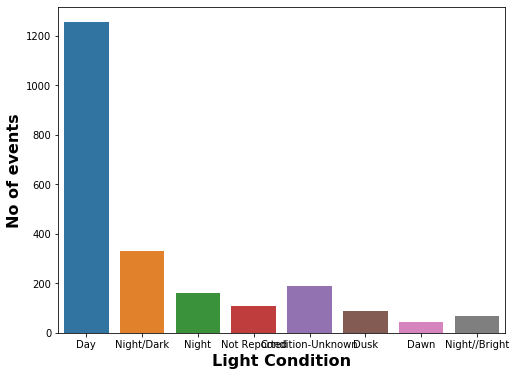

In [39]:
plt.figure(figsize = (8, 6))
sns.barplot(light_cond_keys, list(light_cond_counter.values()))
plt.xlabel('Light Condition', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Engine Type

In [40]:
eng_type_counter = collections.Counter(engines['eng_type'].fillna('Not Reported'))
eng_type_keys = ['Turbo Fan', 'Turbo Prop', 'Unknown', 'Turbo Jet', 'Reciprocating', 'Not Reported', 'Turbo Shaft']

Text(0, 0.5, 'No of events')

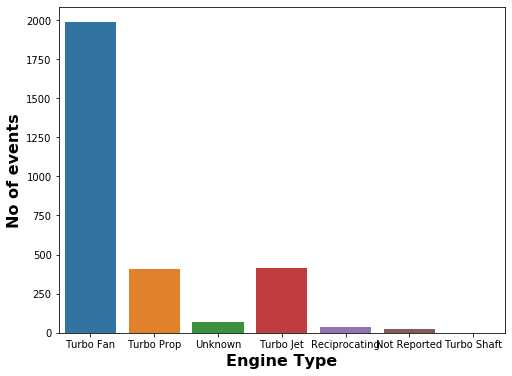

In [41]:
plt.figure(figsize = (8, 6))
sns.barplot(eng_type_keys, list(eng_type_counter.values()))
plt.xlabel('Engine Type', fontsize = 16, fontweight = 'bold')
plt.ylabel('No of events', fontsize = 16, fontweight = 'bold')

#### Accident vs Airframe Hours

Text(0, 0.5, 'Probability')

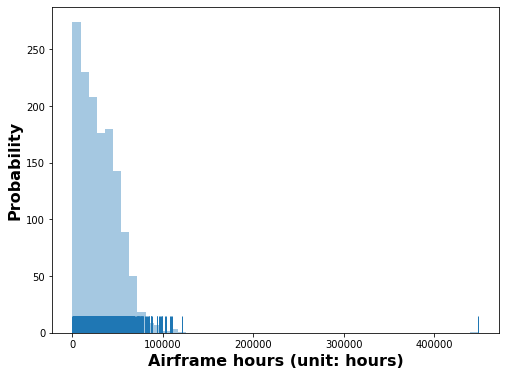

In [42]:
afm_hrs = aircraft['afm_hrs'].values
afm_hrs = afm_hrs[~np.isnan(afm_hrs)]

plt.figure(figsize = (8, 6))
sns.distplot(afm_hrs, kde=False, rug=True)
plt.xlabel('Airframe hours (unit: hours)', fontsize = 16, fontweight = 'bold')
plt.ylabel('Probability', fontsize = 16, fontweight = 'bold')

#### Aircraft Basic Characteristics

In [43]:
aircraft['num_eng']

0       2.0
1       2.0
2       3.0
3       2.0
4       4.0
       ... 
2303    2.0
2304    NaN
2305    2.0
2306    2.0
2307    2.0
Name: num_eng, Length: 2308, dtype: float64

In [44]:
aircraft['oper_pax_cargo']

0        PAX
1       CARG
2       PACA
3       PACA
4       PACA
        ... 
2303     PAX
2304     PAX
2305     PAX
2306     PAX
2307     PAX
Name: oper_pax_cargo, Length: 2308, dtype: object

In [45]:
events['light_cond']

0       DAYL
1       DAYL
2       DAYL
3       DAYL
4       DAYL
        ... 
2238    DAYL
2239      NR
2240    NITE
2241    DAYL
2242    DAYL
Name: light_cond, Length: 2243, dtype: object

In [46]:
import pygraphviz as pgv
from IPython.display import display, Image

def drawImage(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

def drawPDF(dot, fileName):
    return pgv.AGraph(dot).draw(fileName + '.pdf', prog='dot')

In [47]:
ev_ID

['20001213X26438',
 '20120802X03552',
 '20001208X08071',
 '20020917X01911',
 '20001214X43232',
 '20010110X00148',
 '20001214X37434',
 '20020506X00632',
 '20001212X22783',
 '20001211X11205',
 '20001205X00380',
 '20110607X83931',
 '20001213X35054',
 '20070418X00436',
 '20001214X39783',
 '20001207X04839',
 '20190311X35306',
 '20001212X24012',
 '20001214X43270',
 '20001212X21420',
 '20001211X13905',
 '20001212X22523',
 '20020917X03104',
 '20060711X00910',
 '20001212X23667',
 '20030410X00473',
 '20131122X05100',
 '20001212X18966',
 '20010110X00108',
 '20060131X00140',
 '20001208X07902',
 '20001208X08916',
 '20030501X00608',
 '20001214X45014',
 '20130314X15433',
 '20001208X07863',
 '20021010X05313',
 '20150211X14605',
 '20001206X02242',
 '20050825X01311',
 '20001213X26074',
 '20001214X38202',
 '20160216X30252',
 '20001212X22066',
 '20020731X01263',
 '20001214X44807',
 '20141217X43728',
 '20001213X25384',
 '20001212X24506',
 '20161205X55455',
 '20110209X55126',
 '20001214X38342',
 '20001208X0

##### Derive the consequence of incident as represented by two indicators: personnel injury and aircraft damage
- Personnel injury: fatal, serious, minor, or none
- Aircraft damage: destroyed, substantial, minor, or none

In [110]:
import re
def calculate_injury_level(ev_ID):    
    Fatal = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'FATL')]['inj_person_count'].values)
    Serious = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'SERS')]['inj_person_count'].values)
    Minor = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'MINR')]['inj_person_count'].values)
    No = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'NONE')]['inj_person_count'].values)
    Total = sum(injury[(injury['ev_id'] == sample_ev_ID) & (injury['injury_level'] == 'TOTL')]['inj_person_count'].values)
    
    dict_injury = {}
    if Total != 0:
        dict_injury['Fatal'] = Fatal/Total
        dict_injury['Serious'] = Serious/Total
        dict_injury['Minor'] = Minor/Total
        dict_injury['NONE'] = No/Total
        
        if dict_injury['Fatal'] > 0:
            return 'Fatalinjury'
        elif dict_injury['Serious'] > 0:
            return 'Seriousinjury'
        elif dict_injury['Minor'] > 0:
            return 'Minorinjury'
        else:
            return 'Noinjury'
    else:
        return 'Noinjury'

###### Derive the meaning from code 

In [111]:
def deriveNamebyCode(code):
    try:
        label = metaData[metaData['code_iaids'] == code]['meaning'].values[0]
        name = re.sub('[^a-zA-Z]+', '', label)  
    except:
        return 'Unknownquantity', 'Unknown quantity'
    
    return name, label

#### A demo on graphical representation of accident occurrences

In [112]:
#sample_ev_ID = '20001213X29335'
sample_ev_ID = '20001213X29335'
example = narratives[narratives['ev_id'] == sample_ev_ID]
list(example['narr_accp'])

[nan]

In [113]:
sample_ev_ID

'20001213X29335'

##### Identify event causes and contributory factors

In [114]:
seq_of_events[seq_of_events['ev_id'] == sample_ev_ID]

,ev_id,Aircraft_Key,Occurrence_No,seq_event_no,group_code,Subj_Code,Cause_Factor,Modifier_Code,Person_Code,lchg_date,lchg_userid
165126,20001213X29335,1,1,1,2,22120,C,3109,4000.0,12/13/2000 13:05:36,dbo
165127,20001213X29335,1,2,1,2,24505,C,3104,4000.0,12/13/2000 13:05:36,dbo


##### Find the event consequences

In [115]:
occurrences[occurrences['ev_id'] == sample_ev_ID]

,ev_id,Aircraft_Key,Occurrence_No,Occurrence_Code,Phase_of_Flight,Altitude,lchg_date,lchg_userid
63571,20001213X29335,1,1,260,521,0,12/13/2000 13:05:36,dbo
63572,20001213X29335,1,2,340,523,0,12/13/2000 13:05:36,dbo
63573,20001213X29335,1,3,310,523,0,12/13/2000 13:05:36,dbo


##### Create functions to build the network consisting of nodes and edges

In [116]:
dictEdges = {}

lst = ['eventId', 'from', 'to']
df_records = pd.DataFrame(columns=lst)

def addEdges(key, ev_ID):
    if key in dictEdges.keys():
        dictEdges[key] += 1
    else:
        dictEdges[key] = 1
    
    global df_records
    fromNode, toNode = key.split('->')
    row = {'eventId': ev_ID, 'from': fromNode, 'to': toNode}
    df_records = df_records.append(row, ignore_index=True)
    
    
dictNodeLabel = {}
def addNodeLabel(key, value):
    if key == 'Flightcrew':
        dictNodeLabel[key] = 'Flight crew'
        return
    if key not in dictNodeLabel.keys():
        dictNodeLabel[key] = value
        
dictNodeLabel['Fatalinjury'] = 'Fatal injury'
dictNodeLabel['Seriousinjury'] = 'Serious injury'
dictNodeLabel['Minorinjury'] = 'Minor injury'
dictNodeLabel['Noinjury'] = 'No injury'
dictNodeLabel['Unknownreason'] = 'Unknown reason'

#### Build graphical representations for the escalation of initiating events

In [117]:
def buildOneGraphRep(sample_ev_ID):

    g1 = "digraph top {"
    g1 += """size ="12,12"; """
    g1 += "graph [compound=true];"
    
    # Query the year that the accident happened
    ev_year = events[events['ev_id'] == sample_ev_ID]['ev_year'].values[0]
    
    if ev_year <= 2006:
        eventSequences = seq_of_events[seq_of_events['ev_id'] == sample_ev_ID][['Occurrence_No', 'seq_event_no', 
                                                                  'Subj_Code', 'Modifier_Code', 'Person_Code']]

        ## Construct the subject name
        subjectList = []
        for index, row in eventSequences.iterrows():
            Subj_Code = str(int(row['Subj_Code']))
            Modifier_Code = str(int(row['Modifier_Code']))
            Person_Code = str(int(row['Person_Code']))
            Occurrence_No = int(row['Occurrence_No'])

            subjectName, subjectLabel = deriveNamebyCode(Subj_Code)
            
            if Modifier_Code != '0':
                modifierName, modifierLabel = deriveNamebyCode(Modifier_Code)
                
                if len(modifierName) > 0:
                    subjectName = subjectName #+ modifierName
                    subjectLabel = subjectLabel #+ ':' + modifierLabel

            g1 += subjectName + ' [label =' + '"' + subjectLabel + '"'+ '];'
            subjectList.append([Occurrence_No, subjectName])
            addNodeLabel(subjectName, subjectLabel)

            if Person_Code != '0':
                personName, personeLabel = deriveNamebyCode(Person_Code)
                g1 += personName + '[label = ' + '"' + personeLabel + '"' + '];'
                g1 += personName + '->' + subjectName + ';'
                addEdges(personName + '->' + subjectName, sample_ev_ID)
                addNodeLabel(personName, personeLabel)

        ## construct sequence of occurrence
        eventOccurrences = occurrences[occurrences['ev_id'] == sample_ev_ID][['Occurrence_Code', 'Phase_of_Flight']]
        occurrenceCount = 0
        OccurrenceName = ''
        
        for index, row in eventOccurrences.iterrows():
            Occurrence_Code = str(row['Occurrence_Code'])
            Phase_of_Flight = str(row['Phase_of_Flight'])

            prevOccurrence = OccurrenceName
            OccurrenceName, OccurrenceLabel  = deriveNamebyCode(Occurrence_Code)
            flightPhaseName, flightPhaseLabel = deriveNamebyCode(Phase_of_Flight)

            g1 += OccurrenceName + ' [label = ' + '"' + OccurrenceLabel + '"' + ', style=filled, color=".2 .5 0.9"];'
            addNodeLabel(OccurrenceName, OccurrenceLabel)
            addNodeLabel(flightPhaseName, flightPhaseLabel)
            
            for subject in subjectList:
                if subject[0] == occurrenceCount + 1:
                    connection = subject[1] + '->' + OccurrenceName + ';'
                    if connection not in g1:
                        g1 += subject[1] + '->' + OccurrenceName + ';'
                        addEdges(subject[1] + '->' + OccurrenceName, sample_ev_ID)
            
            if occurrenceCount == 0:
                #g1 += flightPhaseName + ' [label = ' + '"' + flightPhaseLabel + '"' + '];'
                #g1 += flightPhaseName + '->' + OccurrenceName + ';'
                #addEdges(flightPhaseName + '->' + OccurrenceName)
                pass
            
            if occurrenceCount >= 1:
                g1 += prevOccurrence + '->' + OccurrenceName + ';'
                #g1 += flightPhaseName + ' [label = ' + '"' + flightPhaseLabel + '"' + '];'
                #g1 += flightPhaseName + '->' + OccurrenceName + ';'
                
                addEdges(prevOccurrence + '->' + OccurrenceName, sample_ev_ID)
                #addEdges(flightPhaseName + '->' + OccurrenceName)

            occurrenceCount += 1

        ## Outcome of accident
        aircraftDamageLevel = aircraft[aircraft['ev_id'] == sample_ev_ID]['damage'].values[0]
        aircraftDamageName = dictAircraftDamage[aircraftDamageLevel] + 'aircraftdamage'
        aircraftDamageLabel = dictAircraftDamage[aircraftDamageLevel] + ' aircraft damage'
        addNodeLabel(aircraftDamageName, aircraftDamageLabel)
        
        g1 += aircraftDamageName + '[label = ' + '"'+ aircraftDamageLabel + '"' +', style=filled];'
        
        if OccurrenceName == '':
            OccurrenceName = 'Unknownreason'
            
        g1 += OccurrenceName + '->' + aircraftDamageName + ';'
        addEdges(OccurrenceName + '->' + aircraftDamageName, sample_ev_ID)

        injuryLevel = calculate_injury_level(sample_ev_ID)
        
        g1 += injuryLevel + '[label = ' + '"'+ dictNodeLabel[injuryLevel] + '"' +', style=filled];'
        g1 += OccurrenceName + '->' + injuryLevel + ';'
        addEdges(OccurrenceName + '->' + injuryLevel, sample_ev_ID)

        g1 += "}"
        
        return g1

#### Demo of graphical representation

In [118]:
sample_ev_ID

'20001213X29335'

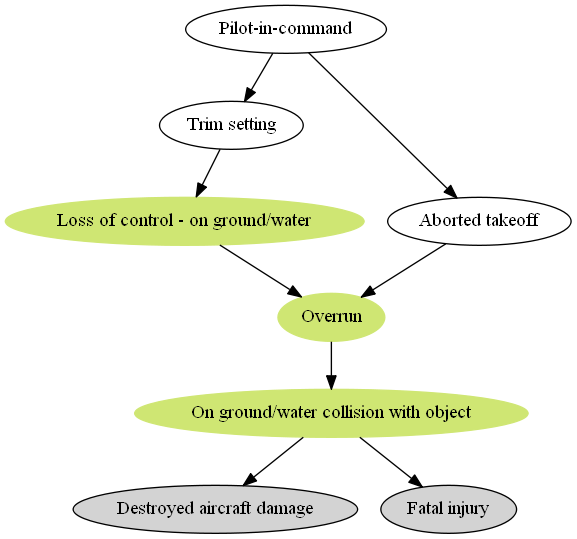

In [119]:
dictAircraftDamage = {'MINR': 'Minor', 'DEST': 'Destroyed', 'NONE': 'None', 'UNK': 'Unknown', 'SUBS': 'Substantial'}
dictEdges = {}
g1 = buildOneGraphRep(sample_ev_ID)
drawImage(g1)
#drawPDF(g1, 'test')

#### Add all the connections for accidents before 2006

In [120]:
dictEdges = {}
for sample_ev_ID in ev_ID:
    #print (sample_ev_ID)
    buildOneGraphRep(sample_ev_ID)

In [121]:
df_records

,eventId,from,to
0,20001213X29335,Pilotincommand,Trimsetting
1,20001213X29335,Pilotincommand,Abortedtakeoff
2,20001213X29335,Trimsetting,Lossofcontrolongroundwater
3,20001213X29335,Abortedtakeoff,Overrun
4,20001213X29335,Lossofcontrolongroundwater,Overrun
...,...,...,...
11261,20001208X07943,Lossofenginepowertotalnonmechanical,Fire
11262,20001208X07943,Hydraulicsystem,Overrun
11263,20001208X07943,Fire,Overrun
11264,20001208X07943,Overrun,Substantialaircraftdamage


In [122]:
setCauses = set(df_records['from'].values)

dictElement = {}

for cause in setCauses:
    outcomes = set(df_records[(df_records['from'] == cause)]['to'].values)
    
    for outcome in outcomes:
        #print ('no causes: ', no_causes)

        key = cause + '->' + outcome

        jointEvents = set(df_records[(df_records['to'] == outcome) & (df_records['from'] == cause)]['eventId'].values)
        denominator = set(df_records[(df_records['from'] == cause) | (df_records['to'] == cause)]['eventId'].values)

        if key not in dictElement.keys():
            dictElement[key] = len(jointEvents)/len(denominator)
            
            if dictElement[key] == 1:
                dictElement[key] = dictElement[key] * 0.95

In [123]:
dictElement

{'Dispatch->Miscellaneousother': 0.5,
 'Dispatch->Inflightencounterwithweather': 0.5,
 'Goaround->Inflightcollisionwithterrainwater': 0.07142857142857142,
 'Goaround->Inflightcollisionwithobject': 0.07142857142857142,
 'Goaround->Wheelsuplanding': 0.07142857142857142,
 'Goaround->Overrun': 0.35714285714285715,
 'Goaround->Hardlanding': 0.21428571428571427,
 'Goaround->Lossofcontrolongroundwater': 0.07142857142857142,
 'Goaround->Draggedwingrotorpodfloatortailskid': 0.14285714285714285,
 'Miscellaneousengineuncontainedfailure->Lossofenginepowertotalmechanicalfailuremalfunction': 0.5,
 'Miscellaneousengineuncontainedfailure->Lossofenginepowerpartialmechanicalfailuremalfunction': 0.5,
 'Companyinducedpressure->Miscellaneousother': 0.95,
 'Plannedapproach->Overrun': 0.4,
 'Plannedapproach->Vortexturbulenceencountered': 0.2,
 'Plannedapproach->Lossofcontrolongroundwater': 0.2,
 'Plannedapproach->Inflightencounterwithweather': 0.2,
 'AirspeedliftoffspeedVlof->Ongroundwatercollisionwithterrai

In [124]:
setCauses

{'ATCclearance',
 'ATCpersonnelAirRouteTrafficControlCenterARTCC',
 'ATCpersonnelFlightServiceStationFSS',
 'ATCpersonneldepartureapproach',
 'ATCpersonnellocalgroundclearancedelivery',
 'ATCpersonnelnonFAA',
 'ATCpersonnelsupervisor',
 'Abort',
 'AbortaboveV',
 'Abortedlanding',
 'Abortedtakeoff',
 'Abruptmaneuver',
 'Accessorydriveassembly',
 'Accessorydriveassemblydrivegear',
 'Accessorydriveassemblydriveshaft',
 'Accessorydriveassemblyextensionunit',
 'Accessorydriveassemblyexternalshaftbearing',
 'Ailerontrim',
 'AirRouteTrafficControlCenterARTCCservice',
 'Airconditioningheatingpressurization',
 'Airconditioningheatingpressurizationcabintemperaturecontrol',
 'Airconditioningheatingpressurizationcontrolindicator',
 'Airconditioningheatingpressurizationfreonsystem',
 'Airconditioningheatingpressurizationoutflowvalve',
 'Airconditioningheatingpressurizationpressureregulator',
 'Airconditioningheatingpressurizationsafetyvalve',
 'Aircraftcontrol',
 'Aircraftequipmentinadequate',
 'Ai

In [125]:
dictEdges

{'Groundpersonnel->Clearance': 25,
 'Clearance->Ongroundwatercollisionwithobject': 61,
 'Ongroundwatercollisionwithobject->Ongroundwatercollisionwithobject': 30,
 'Ongroundwatercollisionwithobject->Minoraircraftdamage': 64,
 'Ongroundwatercollisionwithobject->Noinjury': 164,
 'Otherperson->Communications': 1,
 'Otherperson->Procedureinadequate': 2,
 'Communications->Nearcollisionbetweenaircraft': 4,
 'Procedureinadequate->Nearcollisionbetweenaircraft': 1,
 'Nearcollisionbetweenaircraft->Noneaircraftdamage': 59,
 'Nearcollisionbetweenaircraft->Noinjury': 58,
 'Manufacturer->Aircraftequipmentinadequateaircraftmanuals': 4,
 'unspecifiedperson->Reasonforoccurrenceundetermined': 38,
 'Companyoperatormanagement->Instructionswrittenverbal': 1,
 'Passenger->Interpretationofinstructions': 1,
 'Weathercondition->Lossofenginepowerpartialnonmechanical': 4,
 'Fluidfuel->Lossofenginepowerpartialnonmechanical': 1,
 'Fuelsystemfilter->Lossofenginepowerpartialnonmechanical': 1,
 'Aircraftequipmentinade

In [126]:
len(dictElement)

3158

In [127]:
len(dictEdges)

3158

#### Construct a dataframe to represent all the links in the network

In [128]:
lst = ['name', 'fromID', 'toID', 'count']
df_edges = pd.DataFrame(columns = lst)

for key, value in dictEdges.items():
    name = key
    fromID, toID = str(key).split('->')
    count = dictElement[key]
    
    row = {'name': key, 'fromID': fromID, 'toID': toID, 'count': count}
    df_edges = df_edges.append(row, ignore_index=True)

In [129]:
df_records[df_records['to'] == 'Inflightencounterwithweather']

,eventId,from,to
60,20001214X37434,Weathercondition,Inflightencounterwithweather
61,20001214X37434,Inflightweatheravoidanceassistance,Inflightencounterwithweather
62,20001214X37434,Inadequatesurveillanceofoperationinsufficients...,Inflightencounterwithweather
63,20001214X37434,Flightadvisories,Inflightencounterwithweather
64,20001214X37434,Flightintoknownadverseweather,Inflightencounterwithweather
...,...,...,...
11115,20001213X26441,Weathercondition,Inflightencounterwithweather
11116,20001213X26441,Clearance,Inflightencounterwithweather
11117,20001213X26441,Weatherradar,Inflightencounterwithweather
11118,20001213X26441,Airspeed,Inflightencounterwithweather


In [130]:
parentInfo = df_edges[df_edges['toID'] == 'Inflightencounterwithweather'][['fromID', 'count']].values
sorted(parentInfo, key=lambda x: x[1], reverse = True)

[array(['Preflightbriefingservice', 0.95], dtype=object),
 array(['Weatherforecast', 0.95], dtype=object),
 array(['Inflightweatheradvisories', 0.95], dtype=object),
 array(['Miscellaneousequipmentfurnishingsfirstaidequipment', 0.95],
       dtype=object),
 array(['Meteorologicalservice', 0.95], dtype=object),
 array(['Flightcontrolelevatorsurface', 0.95], dtype=object),
 array(['Flightnavigationinstrumentsairspeedindicator', 0.95], dtype=object),
 array(['Pressure', 0.95], dtype=object),
 array(['Weatherradar', 0.95], dtype=object),
 array(['Flightintoadverseweather', 0.9230769230769231], dtype=object),
 array(['Seatbeltsign', 0.8571428571428571], dtype=object),
 array(['Passengerbriefing', 0.8333333333333334], dtype=object),
 array(['Hazardousweatheradvisory', 0.8333333333333334], dtype=object),
 array(['Seatbelt', 0.8292682926829268], dtype=object),
 array(['Flightintoknownadverseweather', 0.6666666666666666], dtype=object),
 array(['Crewgroupbriefing', 0.625], dtype=object),
 array

### Construct Bayesian network with PySMILE library

#### Construct XDSL file to be fed into PySMILE

In [131]:
import numpy as np
from scipy.optimize import minimize

def CPT_estimation(x, a, b):
    return (1 + np.exp(a+b))/(1 + np.exp(a/x + b))

def obj(x, normProb, probs):
    diff = (1 + np.exp(x[0]+x[1]))/(1 + np.exp(x[0]/normProb + x[1])) - probs
    return np.sum(diff**2)

In [132]:
def binaryConversion(value, n):
    m = eval('"' + "{0:0" + str(n) + "b}" + '"').format(value) ## binary representation
    characters = [int(char) for char in str(m)]
    res = np.array(characters)
    return res

In [133]:
dictParameter = {}

def constructCPT(parentInfo, toID):
    n = parentInfo.shape[0]
    count = parentInfo[:, 1]

    start = 2**n - 1
    
    CPT = []
    lambda_val = sum(count) - 1
    for i in range(start, -1, -1):
        scheme = binaryConversion(i, n)
        
        if sum(scheme) == 1 or sum(scheme) == 0:
            Yes_prob = np.sum(np.multiply(scheme, count))
        else:
            totalContribution = np.sum(count)
            normContribution = count/totalContribution
            
            normContribution = np.array([min(normContribution), max(normContribution)])
            probs = np.array([min(count), max(count)])
            
            if toID not in dictParameter.keys():
                ## calibrate the parameters
                x_0 = [-1, 1]
                res = minimize(obj, x_0, args = (normContribution, probs), method='Powell', tol=1e-6)

                a = res.x[0]
                b = res.x[1]
                
                dictParameter[toID] = [a, b]
                
                print ('Obj: ', res.fun, 'a:', a, 'b: ', b)
            else:
                a = dictParameter[toID][0]
                b = dictParameter[toID][1]
            
            CPT_contribution = np.sum(np.multiply(scheme, count))/totalContribution
            Yes_prob = CPT_estimation(CPT_contribution, a, b)
            
            if Yes_prob < max(np.multiply(scheme, count)):
                Yes_prob = max(np.multiply(scheme, count))
                
            #print (Yes_prob, max(np.multiply(scheme, count)))
            
            assert Yes_prob >= max(np.multiply(scheme, count))
            
        No_prob = 1 - Yes_prob
        
        CPT.append(Yes_prob)
        CPT.append(No_prob)
    
    return CPT

def occurrenceTimes(toID):
    toID = set(df_records[df_records['to'] == toID]['eventId'].values)
    fromID = set(df_records[df_records['from'] == toID]['eventId'].values)
    return len(toID.union(fromID))

def occurrenceTimesFromID(fromID):
    return len(set(df_records[df_records['from'] == fromID]['eventId'].values))

In [134]:
#parentInfo = df_edges[df_edges['toID'] == 'Fire'][['fromID', 'count']].values
#constructCPT(parentInfo, 'Fire')

##### Load the license

In [73]:
import pysmile

## load license
pysmile.License((
    b"SMILE LICENSE cd06be93 97a7a599 29f4a47f "
    b"THIS IS AN ACADEMIC LICENSE AND CAN BE USED "
    b"SOLELY FOR ACADEMIC RESEARCH AND TEACHING, "
    b"AS DEFINED IN THE BAYESFUSION ACADEMIC "
    b"SOFTWARE LICENSING AGREEMENT. "
    b"Serial #: ckw9n4254hey3kiszvj6n5k0b "
    b"Issued for: Xiaoge Zhang (zxgcqupt@gmail.com) "
    b"Academic institution: Vanderbilt University "
    b"Valid until: 2020-03-22 "
    b"Issued by BayesFusion activation server"
    ),[
    0xf5,0xdc,0x56,0x91,0x01,0x05,0xdb,0x8d,0xf0,0xbf,0x21,0xe9,0x58,0x09,0x41,0x79,
    0x1f,0xd8,0xd4,0xb3,0x0a,0xaf,0x09,0xad,0xf2,0x41,0x58,0x93,0xc2,0x51,0x28,0xb0,
    0x8d,0xad,0x69,0x38,0x8d,0x82,0x43,0x01,0xca,0xd9,0xd3,0xa2,0x5c,0x98,0xe2,0x9a,
    0x99,0xbf,0xa4,0x17,0x4f,0xbb,0xd6,0x9a,0x72,0xf4,0x23,0xf5,0xed,0x94,0x4b,0x8e])

##### Define the denominator to represent the number of flights from 1982 to 2006

In [135]:
dictEdges

{'Groundpersonnel->Clearance': 25,
 'Clearance->Ongroundwatercollisionwithobject': 61,
 'Ongroundwatercollisionwithobject->Ongroundwatercollisionwithobject': 30,
 'Ongroundwatercollisionwithobject->Minoraircraftdamage': 64,
 'Ongroundwatercollisionwithobject->Noinjury': 164,
 'Otherperson->Communications': 1,
 'Otherperson->Procedureinadequate': 2,
 'Communications->Nearcollisionbetweenaircraft': 4,
 'Procedureinadequate->Nearcollisionbetweenaircraft': 1,
 'Nearcollisionbetweenaircraft->Noneaircraftdamage': 59,
 'Nearcollisionbetweenaircraft->Noinjury': 58,
 'Manufacturer->Aircraftequipmentinadequateaircraftmanuals': 4,
 'unspecifiedperson->Reasonforoccurrenceundetermined': 38,
 'Companyoperatormanagement->Instructionswrittenverbal': 1,
 'Passenger->Interpretationofinstructions': 1,
 'Weathercondition->Lossofenginepowerpartialnonmechanical': 4,
 'Fluidfuel->Lossofenginepowerpartialnonmechanical': 1,
 'Fuelsystemfilter->Lossofenginepowerpartialnonmechanical': 1,
 'Aircraftequipmentinade

In [136]:
dictEdges.items()

dict_items([('Groundpersonnel->Clearance', 25), ('Clearance->Ongroundwatercollisionwithobject', 61), ('Ongroundwatercollisionwithobject->Ongroundwatercollisionwithobject', 30), ('Ongroundwatercollisionwithobject->Minoraircraftdamage', 64), ('Ongroundwatercollisionwithobject->Noinjury', 164), ('Otherperson->Communications', 1), ('Otherperson->Procedureinadequate', 2), ('Communications->Nearcollisionbetweenaircraft', 4), ('Procedureinadequate->Nearcollisionbetweenaircraft', 1), ('Nearcollisionbetweenaircraft->Noneaircraftdamage', 59), ('Nearcollisionbetweenaircraft->Noinjury', 58), ('Manufacturer->Aircraftequipmentinadequateaircraftmanuals', 4), ('unspecifiedperson->Reasonforoccurrenceundetermined', 38), ('Companyoperatormanagement->Instructionswrittenverbal', 1), ('Passenger->Interpretationofinstructions', 1), ('Weathercondition->Lossofenginepowerpartialnonmechanical', 4), ('Fluidfuel->Lossofenginepowerpartialnonmechanical', 1), ('Fuelsystemfilter->Lossofenginepowerpartialnonmechanical'

In [137]:
maxElements = 18

def searchThreshold(parentInfo):
    threshold = 0
    
    m = len(np.where(parentInfo[:, 1] > threshold)[0])
    
    while m > maxElements:
        if m < maxElements:
            threshold -= min(parentInfo[:, 1])
        else:
            threshold += min(parentInfo[:, 1])
   
        m = len(np.where(parentInfo[:, 1] > threshold)[0])
    
    if threshold > max(parentInfo[:, 1]):
        threshold = max(parentInfo[:, 1])
    
    return threshold

###### Compute the total number of scheduled flights within USA

In [138]:
departures = pd.read_excel('table_01_37_061019.xlsx')
departures.drop(departures.columns[0], axis=1, inplace= True)

In [139]:
years = departures.iloc[0].index
flights = departures.iloc[0].values

In [140]:
years = [int(i) for i in years]

Text(0, 0.5, 'Scheduled flights')

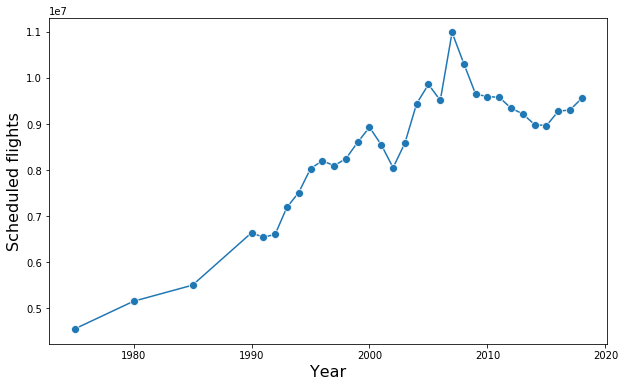

In [141]:
plt.figure(figsize=(10, 6))
sns.lineplot(years, flights, marker = 'o', markersize = 8)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Scheduled flights', fontsize = 16)

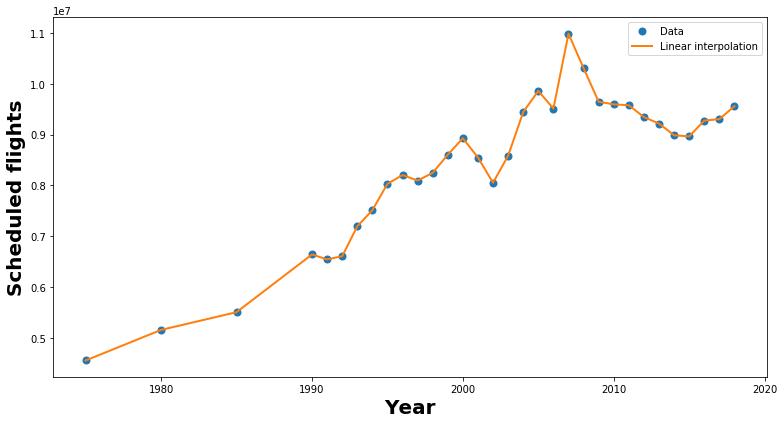

In [142]:
from scipy.interpolate import interp1d

f = interp1d(years, flights)
xnew = np.linspace(1975, 2018, num = 44, endpoint=True)

ax = plt.figure(figsize=(11, 6))
plt.plot(years, flights, 'o', xnew, f(xnew), '-', markersize = 7, linewidth=2)
plt.legend(['Data', 'Linear interpolation'], loc='best')
plt.xlabel('Year', fontsize = 20, fontweight = 'bold')
plt.ylabel('Scheduled flights', fontsize = 20, fontweight = 'bold')
plt.tight_layout()

plt.savefig('departures.pdf')

In [143]:
totalFlights = 0
for i in range(1982, 2007, 1):
    totalFlights += f(i)

In [144]:
totalFlights = round(totalFlights)
print ('The total number of flights from 1982 to 2006 is', totalFlights)

The total number of flights from 1982 to 2006 is 184517128.0


##### Prior probability estimation

In [145]:
set(df_records['to'].values)

{'ATCclearance',
 'Abort',
 'AbortaboveV',
 'Abortedlanding',
 'Abortedtakeoff',
 'Abruptmaneuver',
 'Ailerontrim',
 'AirRouteTrafficControlCenterARTCCservice',
 'Aircraftcontrol',
 'Aircraftequipmentinadequate',
 'Aircraftequipmentinadequateaircraftcomponent',
 'Aircraftequipmentinadequateaircraftmanuals',
 'Aircraftequipmentinadequateairframe',
 'Aircraftequipmentinadequatecompliancedetermination',
 'Aircraftequipmentinadequatecontrolshapesize',
 'Aircraftequipmentinadequatedesign',
 'Aircraftequipmentinadequatehandlingperformancecapabilities',
 'Aircraftequipmentinadequatestandardrequirement',
 'Aircrafthandling',
 'Aircraftpreflight',
 'Aircraftservice',
 'Aircraftweightandbalance',
 'Airframecomponentsystemfailuremalfunction',
 'Airgroundcommunications',
 'Airport',
 'Airportoperations',
 'Airportsnowremoval',
 'Airspeed',
 'AirspeedliftoffspeedVlof',
 'AirspeedminimumcontrolspeedwiththecriticalengineinoperativeVmc',
 'AirspeedreferenceVref',
 'AirspeedrotationspeedVr',
 'Allavail

In [146]:
event = 'Fire'

In [147]:
eventID_list = set(df_records[(df_records['from'] == event) | (df_records['to'] == event)]['eventId'].values)
totalOccurrences = len(eventID_list)
prob_yes = totalOccurrences/totalFlights
prob_no = 1 - prob_yes
print ('Total occurrences of event %s: %d' % (event, totalOccurrences))
print ('Prior probability of fire occurrence is: ', prob_yes)

Total occurrences of event Fire: 102
Prior probability of fire occurrence is:  5.527942099770814e-07


In [148]:
df_records[df_records['eventId'] == '20050209X00169']

,eventId,from,to
5057,20050209X00169,Flightcrew,Visuallookout
5058,20050209X00169,Airportpersonnel,Airport
5059,20050209X00169,FAAotherorganization,Airport
5060,20050209X00169,Visuallookout,Miscellaneousother
5061,20050209X00169,Airport,Miscellaneousother
5062,20050209X00169,Miscellaneousother,Noneaircraftdamage
5063,20050209X00169,Miscellaneousother,Noinjury


##### Conditional probability estimation

In [149]:
causes = set(df_records[df_records['to'] == event]['from'].values)

total = 0
maxOccurrence = -1
prob_set = []
for cause in causes:
    cause_occurrences = len(set(df_records[(df_records['from'] == cause) & (df_records['to'] == event)]['eventId'].values))
    
    #print ('Cause: ', dictNodeLabel[cause], ', Occurrence: ', cause_occurrences, ', Prob: ', cause_occurrences/totalOccurrences)
    
    total += cause_occurrences/totalOccurrences
    prob_set.append(cause_occurrences/totalOccurrences)
    
    
    if cause_occurrences > maxOccurrence:
        maxOccurrence = cause_occurrences
        
print ('The maximum number of occurrence is', maxOccurrence)

The maximum number of occurrence is 32


In [150]:
set(prob_set)

{0.00980392156862745,
 0.0196078431372549,
 0.029411764705882353,
 0.0392156862745098,
 0.049019607843137254,
 0.058823529411764705,
 0.08823529411764706,
 0.3137254901960784}

In [151]:
total

1.735294117647057

In [152]:
conditional_prob = maxOccurrence/totalOccurrences

In [153]:
totalOccurrences

102

In [154]:
conditional_prob

0.3137254901960784

##### Generate BN

In [155]:
noFlights = totalFlights
random.seed(1)

In [156]:
XDSL = """<?xml version="1.0" encoding="ISO-8859-1"?>
<!-- This network was created in GeNIe Academic, which can be used for educational and research purposes only -->
<smile version="1.0" id="Network1" numsamples="100000000" discsamples="100000000"> """

count = 0

nodeConstructor = "\n\t<nodes>"
extensions = '\n\t<extensions>'
extensions += """\n\t\t<genie version="1.0" app="GeNIe 2.4.4420.0 ACADEMIC" name="Network1" faultnameformat="nodestate">"""

networkNodes = set([])

for key, value in dictEdges.items():
    fromID, toID = key.split('->')
    print (toID)
    parentInfo = df_edges[df_edges['toID'] == toID][['fromID', 'count']].values
    
    indexMaxValues = np.where(parentInfo[:, 1] == max(parentInfo[:, 1]))[0]
    noMaxValues = len(indexMaxValues)
    
    if noMaxValues > maxElements:
        ## inject jitter to the maxvalue
        jitter = [random.random() for i in range(noMaxValues)] 
        jitter = np.array(jitter) * min(parentInfo[:, 1])
        parentInfo[indexMaxValues, 1] = parentInfo[indexMaxValues, 1] + jitter
    
    n = parentInfo.shape[0]
    
    if n > maxElements:
        delta = searchThreshold(parentInfo)
        parentInfo = parentInfo[np.where(parentInfo[:, 1] >= delta), :][0]
        print ('delta: ', delta)
        print (parentInfo)
        
        parentNodeNames = list(parentInfo[:, 0]) 

        for fromID, count in parentInfo:
            if fromID not in networkNodes:
                ## compute prior probabilities
                Yes_prob = occurrenceTimesFromID(fromID)/noFlights
                No_prob = 1 - Yes_prob

                ## construct parent nodes
                nodeConstructor += "\n\t\t<cpt id=" + '"' + fromID + '"' + """>"""
                nodeConstructor += """\n\t\t\t<state id="Yes" />\n\t\t\t<state id="No" />"""
                nodeConstructor += "\n\t\t\t<probabilities>" + str(Yes_prob) + " " +  str(No_prob) + "</probabilities>"
                nodeConstructor += '\n\t\t</cpt>'

                ## add extensions for parent nodes
                extensions += "\n\t\t\t<node id=" +  '"' + fromID + '"' + ">"
                extensions += "\n\t\t\t\t<name>" + dictNodeLabel[fromID] + "</name>"
                extensions += """\n\t\t\t\t<interior color="e5f6f7" />"""
                extensions += """\n\t\t\t\t<outline color="000080" />"""
                extensions += """\n\t\t\t\t<font color="000000" name="Arial" size="8" />"""
                extensions += "\n\t\t\t\t<position> 250 160 426 251 </position>"
                extensions += """\n\t\t\t\t<barchart active="true" width="258" height="64" />"""
                extensions += "\n\t\t\t</node>"

                networkNodes.add(fromID)

        if toID not in networkNodes:
            ## build conditional probability table
            CPT = constructCPT(parentInfo, toID)
            
            CPT_str = list(map(str, CPT))

            childDesp = "\n\t\t<cpt id=" + '"' + str(toID) + '"' + """>"""
            childDesp += """\n\t\t\t<state id="Yes" />\n\t\t\t<state id="No" />"""
            childDesp += "\n\t\t\t<parents>" + ' '.join(parentNodeNames) + "</parents>"
            childDesp += "\n\t\t\t<probabilities>"+ ' '.join(CPT_str)+"</probabilities>"
            childDesp += "\n\t\t</cpt>"

            nodeConstructor += childDesp
            networkNodes.add(toID)

            ## add child node
            extensions += "\n\t\t\t<node id=" +  '"' + toID + '"' + ">"
            extensions += "\n\t\t\t\t<name>" + dictNodeLabel[toID] + "</name>"
            extensions += """\n\t\t\t\t<interior color="e5f6f7" />"""
            extensions += """\n\t\t\t\t<outline color="000080" />"""
            extensions += """\n\t\t\t\t<font color="000000" name="Arial" size="8" />"""
            extensions += "\n\t\t\t\t<position> 250 160 426 251 </position>"
            extensions += """\n\t\t\t\t<barchart active="true" width="258" height="64" />"""
            extensions += "\n\t\t\t</node>"
            
nodeConstructor += "\n\t</nodes>"
extensions += '\n\t\t</genie>'
extensions += '\n\t</extensions>'

Clearance
Ongroundwatercollisionwithobject
delta:  0.5021834061135378
[['Clearance' 0.6931818181818182]
 ['Object' 0.6170212765957447]
 ['Impropertraining' 0.95]
 ['Parkingbrakes' 0.5714285714285714]
 ['Fatiguechronic' 0.95]
 ['Facilityinadequatevisualrestriction' 0.95]
 ['Brakesemergency' 0.95]
 ['Navigationcomputer' 0.95]
 ['Properassistance' 0.5555555555555556]
 ['Strobelights' 0.95]
 ['Altitudeclearance' 0.95]
 ['Wheelchocks' 0.95]
 ['Engineshutdown' 0.95]
 ['Landinggeartowbarattachment' 0.95]
 ['Airportfacilitiesperimeterfence' 0.95]
 ['Airportfacilitiesrunwaymarking' 0.6666666666666666]
 ['Pressureinducedbyconditionsevents' 0.95]
 ['Airportfacilitiescenterlinelights' 0.95]]
Obj:  2.958838735230632e-07 a: 0.23338106942894618 b:  -6.709444063821634
Ongroundwatercollisionwithobject
delta:  0.5021834061135378
[['Clearance' 0.6931818181818182]
 ['Object' 0.6170212765957447]
 ['Impropertraining' 0.95]
 ['Parkingbrakes' 0.5714285714285714]
 ['Fatiguechronic' 0.95]
 ['Facilityinadequatev

Miscellaneousother
delta:  0.9589041095890429
[['Nacellepylonauxiliary' 0.9616086813279072]
 ['Miscellaneousequipmentfurnishingsgalley' 0.9604626660133783]
 ['Bleedairsystem' 0.9589259311331885]
 ['Climb' 0.9608044294676097]
 ['Incapacitationlossofconsciousness' 0.9614488370399982]
 ['Fluidantiiceadditive' 0.9604421929103827]
 ['Nacellepylonattachment' 0.9598841100320654]
 ['Airconditioningheatingpressurizationfreonsystem' 0.962948913637725]
 ['Interpersonalrelations' 0.9623483213371435]
 ['Thrustreverserindicator' 0.9628650570243631]
 ['Physicalimpairmentothercardiovascular' 0.9614736708994872]]
Miscellaneousother
delta:  0.9589041095890429
[['Doorinteriorcrew' 0.9635964850983022]
 ['Miscellaneousequipmentfurnishingsbuffet' 0.9617800894355518]
 ['Climb' 0.9598833480490858]
 ['Incapacitationanoxiahypoxia' 0.9597423530095244]
 ['Incapacitation' 0.9628279532438282]
 ['Exhaustsystem' 0.961370351962662]
 ['Fluidantiiceadditive' 0.9591822680330694]
 ['Nacellepylonattachment' 0.9620887534360

Obj:  0.00021003990758240317 a: 0.2530154701880439 b:  0.9992548352745287
Visuallookout
Communications
Propellerrotorcontacttoperson
Propellerrotorcontacttoperson
Propellerrotorcontacttoperson
Noneaircraftdamage
delta:  0.16666666666666666
[['Nearcollisionbetweenaircraft' 0.8805970149253731]
 ['Inflightencounterwithweather' 0.6855895196506551]
 ['Unknownreason' 0.31092436974789917]
 ['Propellerrotorcontacttoperson' 0.5]
 ['Abruptmaneuver' 0.7407407407407407]
 ['Airframecomponentsystemfailuremalfunction' 0.25968109339407747]
 ['Miscellaneousother' 0.6747967479674797]
 ['Altitudedeviationuncontrolled' 0.7586206896551724]
 ['Lossofcontrolinflight' 0.24]
 ['Forcedlanding' 0.1935483870967742]
 ['Propellerblastorjetexhaustsuction' 0.75]
 ['Lossofenginepowertotalnonmechanical' 0.22727272727272727]
 ['Lossofenginepowerpartialnonmechanical' 0.3]
 ['Overrun' 0.23404255319148937]
 ['Decompression' 0.1875]
 ['Vortexturbulenceencountered' 0.6153846153846154]
 ['Ongroundwaterencounterwithweather' 0.

Obj:  9.675973729702537e-27 a: 0.16448813344506333 b:  -4.796199182875934
Lossofcontrolongroundwater
delta:  0.33333333333333354
[['Taxispeed' 0.5]
 ['Directionalcontrol' 0.8372093023255814]
 ['Ongroundwaterencounterwithweather' 0.75]
 ['Aircraftmanuals' 0.5]
 ['Thrustreversers' 0.5]
 ['Nosewheelsteering' 0.6666666666666666]
 ['Facilityinadequate' 0.5]
 ['Groundloopswerve' 0.95]
 ['Compensationforwindconditions' 0.46153846153846156]
 ['Throttlepowercontrol' 0.35714285714285715]
 ['Hydraulicsystemauxiliarypump' 0.5]
 ['Aircraftperformancehydroplaningcondition' 0.5]
 ['Inadequatetrainingemergencyprocedures' 0.4]
 ['Thrustreverserdoor' 0.95]
 ['Airportfacilitieswinddirectionindicator' 0.95]
 ['Throttlepowerleverbetacontrol' 0.95]
 ['Propellersystemaccessoriesreversingsystem' 0.95]
 ['Aircraftperformancelandingcapability' 0.5]]
Noneaircraftdamage
delta:  0.16666666666666666
[['Nearcollisionbetweenaircraft' 0.8805970149253731]
 ['Inflightencounterwithweather' 0.6855895196506551]
 ['Unknownr

Miscellaneousother
delta:  0.9589041095890429
[['Incapacitation' 0.961724728271678]
 ['Incapacitationotherorganicproblem' 0.9621417528809014]
 ['Communicationnavigationequipmentintercom' 0.9625531154245774]
 ['Nacellepylonattachment' 0.9615724989971688]
 ['Landinggeargearswitch' 0.9593769309981884]
 ['Habitinterference' 0.9634948975875436]
 ['Informationunclearlanguage' 0.9599472124849094]
 ['Physicalimpairmentcardiovascular' 0.9631844499917556]
 ['Companyinducedpressure' 0.9619221674207242]
 ['Pressureinducedbyothers' 0.9617533576255091]
 ['Loadingofcargo' 0.960709125855157]
 ['Incapacitationorganicproblem' 0.9591211433866383]
 ['ShoulderHarness' 0.9629939838606456]]
Miscellaneousother
delta:  0.9589041095890429
[['Hydraulicsystembypassvalve' 0.9632182428075791]
 ['Doorinteriorcrew' 0.9616151773668727]
 ['Incapacitationanoxiahypoxia' 0.9629016702398182]
 ['Incapacitation' 0.9595579503301537]
 ['Communicationnavigationequipmentintercom' 0.9621961921113137]
 ['Fatigueflightschedule' 0.9

Lossofenginepowerpartialmechanicalfailuremalfunction
delta:  0.33485193621867854
[['Turbineassembly' 0.42857142857142855]
 ['Maintenancedesignchange' 0.95]
 ['Combustionassembly' 0.5]
 ['Turbineassemblynozzleretention' 0.5]
 ['Turbineassemblynozzle' 0.5]
 ['Turbineassemblyairseal' 0.6666666666666666]
 ['Turbineassemblyaftfan' 0.95]
 ['Turbineassemblynozzlesupport' 0.95]
 ['Exhaustsystemexhaustconetailpipejetengine' 0.5]
 ['Turboshaftenginepoweroutputshaft' 0.95]
 ['Reductiongearassemblyaccessorydrivebearing' 0.95]
 ['InadequatesubstantiationprocessInadequatedocumentation' 0.5]
 ['Miscellaneousengineuncontainedfailure' 0.5]
 ['Turbineassemblyring' 0.95]
 ['Materialdefectinadequatequalityofmaterial' 0.5]
 ['Fuelsystem' 0.5]
 ['engines' 0.95]
 ['Engineassemblyblowerimpellerintegralsupercharger' 0.95]]
Minoraircraftdamage
delta:  0.32
[['Fire' 0.5098039215686274]
 ['Lossofenginepowerpartialmechanicalfailuremalfunction'
  0.42424242424242425]
 ['Lossofenginepowertotalmechanicalfailuremalfun

delta:  0.5027777777777765
[['Fuelsystemdrain' 0.6666666666666666]
 ['Ignitionsystemignitionharness' 0.95]
 ['Fuelsystemfuelcontrol' 0.6666666666666666]
 ['Exhaustsystemstack' 0.95]
 ['Fuelsystemprimersystem' 0.95]
 ['Enginecompartment' 0.75]
 ['Portableelectricalequipment' 0.95]
 ['Fireextinguisherpowerplant' 0.95]
 ['Cargobaggage' 0.75]
 ['Fireextinguishercargo' 0.6666666666666666]
 ['Ignitionsystemexciter' 0.95]
 ['Startingprocedure' 0.95]
 ['Ignitionsystemigniterplug' 0.95]
 ['Overheatwarningsystem' 0.95]
 ['ElectricalsystemauxiliarypowerunitAPU' 0.95]
 ['Firewarningsystemlavatory' 0.95]
 ['Antiicedeicesystemwindshield' 0.95]
 ['Fireextinguisherportable' 0.95]]
Substantialaircraftdamage
delta:  0.1834061135371178
[['Inflightcollisionwithobject' 0.375]
 ['Ongroundwatercollisionwithobject' 0.5480769230769231]
 ['Unknownreason' 0.29411764705882354]
 ['Nosedown' 0.3333333333333333]
 ['Collisionbetweenaircraftotherthanmidair' 0.4090909090909091]
 ['Hardlanding' 0.5]
 ['Gearcollapsed' 0.

Minoraircraftdamage
delta:  0.32
[['Fire' 0.5098039215686274]
 ['Lossofenginepowerpartialmechanicalfailuremalfunction'
  0.42424242424242425]
 ['Lossofenginepowertotalmechanicalfailuremalfunction' 0.4857142857142857]
 ['Gearnotextended' 0.6875]
 ['Maingearcollapsed' 0.52]
 ['Lossofenginepower' 0.5]
 ['Decompression' 0.5]
 ['Draggedwingrotorpodfloatortailskid' 0.42857142857142855]
 ['Ongroundwatercollisionwithterrainwater' 0.3269230769230769]
 ['Propellerrotorcontacttoperson' 0.5]
 ['Nosedown' 0.6666666666666666]
 ['Collisionbetweenaircraftotherthanmidair' 0.5]
 ['Fireexplosion' 0.5833333333333334]
 ['Propellerfailuremalfunction' 0.95]
 ['Othergearcollapsed' 0.6666666666666666]
 ['Enginetearaway' 0.3333333333333333]
 ['Cargoshift' 0.5]]
Noinjury
delta:  0.6331877729257644
[['Ongroundwatercollisionwithobject' 0.7884615384615384]
 ['Nearcollisionbetweenaircraft' 0.8656716417910447]
 ['Propellerrotorcontacttoperson' 0.95]
 ['Unknownreason' 0.7058823529411765]
 ['Propellerblastorjetexhausts

delta:  0.9547663912682232
[['Autopilotflightdirector' 0.9547663912682232]]
Airframecomponentsystemfailuremalfunction
delta:  0.9548041764022095
[['Flightcontrolsystemruddercontrolcablerod' 0.9548041764022095]]
Airframecomponentsystemfailuremalfunction
delta:  0.9547783317253904
[['Flightcontrolsystemwingslatsystem' 0.9547783317253904]]
Airframecomponentsystemfailuremalfunction
delta:  0.9547660215066548
[['Reductiongearassembly' 0.9547660215066548]]
Windinformation
Overconfidenceinpersonalability
Overconfidenceinaircraftsability
Directionalcontrol
Properalignment
Ongroundwaterencounterwithweather
Ongroundwaterencounterwithweather
Ongroundwaterencounterwithweather
Ongroundwaterencounterwithweather
Ongroundwaterencounterwithweather
Ongroundwaterencounterwithweather
Ongroundwaterencounterwithweather
Lossofcontrolongroundwater
delta:  0.33333333333333354
[['Taxispeed' 0.5]
 ['Directionalcontrol' 0.8372093023255814]
 ['Ongroundwaterencounterwithweather' 0.75]
 ['Aircraftmanuals' 0.5]
 ['Th

delta:  0.04999999999999998
[['Airportfacilitiestaxiwaymarking' 0.25]
 ['Clearance' 0.125]
 ['Collisionbetweenaircraftotherthanmidair' 0.8636363636363636]
 ['Lightcondition' 0.05813953488372093]
 ['Visuallookout' 0.07352941176470588]
 ['Airportfacilitiestaxiwaycondition' 0.1111111111111111]
 ['Unsafehazardousconditionwarning' 0.0625]
 ['Tiedown' 0.5]
 ['Distance' 0.3333333333333333]
 ['NoticetoairmenNOTAMs' 0.16666666666666666]
 ['Visualauraldetection' 0.3333333333333333]
 ['Inadequatesurveillanceofoperationinadequateprocedure'
  0.14285714285714285]
 ['Trafficadvisory' 0.09090909090909091]
 ['Wrongrunway' 0.06666666666666667]
 ['CommunicationsinformationATC' 0.16666666666666666]
 ['RadarairportsurfacedetectionequipmentASDE' 0.95]
 ['Aircraftequipmentinadequate' 0.09090909090909091]
 ['Informationinsufficient' 0.06666666666666667]]
Collisionbetweenaircraftotherthanmidair
delta:  0.04999999999999998
[['Airportfacilitiestaxiwaymarking' 0.25]
 ['Clearance' 0.125]
 ['Collisionbetweenaircra

delta:  0.6331877729257644
[['Ongroundwatercollisionwithobject' 0.7884615384615384]
 ['Nearcollisionbetweenaircraft' 0.8656716417910447]
 ['Propellerrotorcontacttoperson' 0.95]
 ['Unknownreason' 0.7058823529411765]
 ['Propellerblastorjetexhaustsuction' 0.875]
 ['Lossofenginepowerpartialmechanicalfailuremalfunction'
  0.6666666666666666]
 ['Lossofenginepowertotalmechanicalfailuremalfunction' 0.6714285714285714]
 ['Nosedown' 0.95]
 ['Collisionbetweenaircraftotherthanmidair' 0.8181818181818182]
 ['Gearcollapsed' 0.8235294117647058]
 ['Draggedwingrotorpodfloatortailskid' 0.9142857142857143]
 ['Lossofenginepowerpartialnonmechanical' 0.7]
 ['Ditching' 0.95]
 ['Propellerfailuremalfunction' 0.95]
 ['Othergearcollapsed' 0.6666666666666666]
 ['Enginetearaway' 0.8333333333333334]
 ['Gearretractiononground' 0.95]]
AirspeedreferenceVref
Flare
Hardlanding
delta:  0.17073170731707304
[['Properdescentrate' 0.875]
 ['AirspeedreferenceVref' 0.2727272727272727]
 ['Flare' 0.5555555555555556]
 ['Incapacita

delta:  0.9589041095890429
[['Nacellepylonauxiliary' 0.9592308189874428]
 ['Bleedairsystem' 0.9601988302650586]
 ['Incapacitationanoxiahypoxia' 0.9606581471156639]
 ['Incapacitation' 0.960948316770958]
 ['Incapacitationlossofconsciousness' 0.959332318940319]
 ['Exhaustsystem' 0.9590339145662228]
 ['Interpersonalrelations' 0.9634757247906625]
 ['Habitinterference' 0.9618634588652142]
 ['Loadingofcargo' 0.9632467253987268]
 ['Incapacitationorganicproblem' 0.9611262683925881]
 ['ShoulderHarness' 0.9605654137507669]
 ['Airportfacilitiestaxiwaylighting' 0.963268354676765]
 ['Impairmentalcohol' 0.9599413486613789]
 ['Physicalimpairmentothercardiovascular' 0.9609689043671774]]
Miscellaneousother
delta:  0.9589041095890429
[['Hydraulicsystembypassvalve' 0.9615670632988053]
 ['Nacellepylonauxiliary' 0.9612337978577281]
 ['Precautionarylanding' 0.9603306915259745]
 ['Bleedairsystem' 0.9624148035858674]
 ['Climb' 0.963069448615611]
 ['Incapacitationanoxiahypoxia' 0.9629837127953647]
 ['Incapacita

delta:  0.9589041095890429
[['Nacellepylonauxiliary' 0.962564172816037]
 ['Miscellaneousequipmentfurnishingsbuffet' 0.9633076537233252]
 ['Incapacitation' 0.963358235975238]
 ['Incapacitationotherorganicproblem' 0.9605607508858257]
 ['Nacellepylonattachment' 0.9603696025528324]
 ['Airconditioningheatingpressurizationfreonsystem' 0.9616100746452062]
 ['Interpersonalrelations' 0.9636474022978863]
 ['Physicalimpairmentcardiovascular' 0.9612172819822442]
 ['Companyinducedpressure' 0.9609972320176201]
 ['Pressureinducedbyothers' 0.9595683906447393]
 ['Loadingofcargo' 0.9631624347348179]
 ['Anxietyapprehension' 0.9599418858796708]
 ['Airportfacilitiestaxiwaylighting' 0.9605985454037071]
 ['Impairmentalcohol' 0.9597053205561625]]
AirspeedrotationspeedVr
Draggedwingrotorpodfloatortailskid
delta:  0.14350797266514798
[['AirspeedrotationspeedVr' 0.25]
 ['Touchdown' 0.25]
 ['Flightcontrolslat' 0.2]
 ['Remedialaction' 0.15625]
 ['Recoveryfrombouncedlanding' 0.6]
 ['Unsuitableterrainortakeofflandin

delta:  0.9547863213490362
[['Firewarningsystem' 0.9547863213490362]]
Abruptmaneuver
delta:  0.12663755458515277
[['Collisionavoidancesystem' 0.95]
 ['Evasivemaneuver' 0.5]
 ['InsufficientstandardsrequirementsAirwaysairspace' 0.95]
 ['Flightcontrols' 0.2857142857142857]
 ['Altitude' 0.2]
 ['Fatiguecircadianrhythm' 0.5]
 ['MaintenanceapprovedairworthinessinspectionprogramAAIPprogressiveprogram'
  0.2]
 ['Maneuver' 0.5]
 ['Elevator' 0.2]
 ['Aircraftmanuals' 0.5]
 ['Autopilot' 0.14285714285714285]
 ['Approachdeparturecontrolservice' 0.3333333333333333]
 ['Visualseparation' 0.14285714285714285]
 ['Flightcontrolelevator' 0.25]
 ['Emergencyequipment' 0.14285714285714285]
 ['Flightadvisories' 0.16666666666666666]
 ['Installation' 0.5]]
Abruptmaneuver
delta:  0.12663755458515277
[['Collisionavoidancesystem' 0.95]
 ['Evasivemaneuver' 0.5]
 ['InsufficientstandardsrequirementsAirwaysairspace' 0.95]
 ['Flightcontrols' 0.2857142857142857]
 ['Altitude' 0.2]
 ['Fatiguecircadianrhythm' 0.5]
 ['Mainten

Lossofenginepowertotalmechanicalfailuremalfunction
delta:  0.6742596810933936
[['Turbineassemblyturbinewheel' 0.7]
 ['Compressorassemblyvariableinletguidevane' 0.95]
 ['Engineassemblygear' 0.95]
 ['Lubricatingsystemoilportpassageinternal' 0.95]
 ['Engineassemblymasterrod' 0.95]
 ['Combustionassemblyoutercasing' 0.7142857142857143]
 ['Compressorassemblybladeretention' 0.95]
 ['Turbineassemblyshroud' 0.95]
 ['Accessorydriveassemblydriveshaft' 0.95]
 ['Turbineassemblyshaftbearing' 0.75]
 ['Turbineassemblycasing' 0.95]
 ['Turbineassemblyseal' 0.95]
 ['Compressorassemblystatorvane' 0.95]
 ['Compressorassemblywheelretention' 0.95]
 ['Reductiongearassemblyreductiongear' 0.95]
 ['Lubricatingsystemoilmagneticplug' 0.95]
 ['Accessorydriveassemblyextensionunit' 0.95]
 ['Accessorydriveassemblyexternalshaftbearing' 0.95]]
Lossofenginepowertotalmechanicalfailuremalfunction
delta:  0.6742596810933936
[['Turbineassemblyturbinewheel' 0.7]
 ['Compressorassemblyvariableinletguidevane' 0.95]
 ['Engineasse

delta:  0.33485193621867854
[['Turbineassembly' 0.42857142857142855]
 ['Maintenancedesignchange' 0.95]
 ['Combustionassembly' 0.5]
 ['Turbineassemblynozzleretention' 0.5]
 ['Turbineassemblynozzle' 0.5]
 ['Turbineassemblyairseal' 0.6666666666666666]
 ['Turbineassemblyaftfan' 0.95]
 ['Turbineassemblynozzlesupport' 0.95]
 ['Exhaustsystemexhaustconetailpipejetengine' 0.5]
 ['Turboshaftenginepoweroutputshaft' 0.95]
 ['Reductiongearassemblyaccessorydrivebearing' 0.95]
 ['InadequatesubstantiationprocessInadequatedocumentation' 0.5]
 ['Miscellaneousengineuncontainedfailure' 0.5]
 ['Turbineassemblyring' 0.95]
 ['Materialdefectinadequatequalityofmaterial' 0.5]
 ['Fuelsystem' 0.5]
 ['engines' 0.95]
 ['Engineassemblyblowerimpellerintegralsupercharger' 0.95]]
Lossofenginepowerpartialmechanicalfailuremalfunction
delta:  0.33485193621867854
[['Turbineassembly' 0.42857142857142855]
 ['Maintenancedesignchange' 0.95]
 ['Combustionassembly' 0.5]
 ['Turbineassemblynozzleretention' 0.5]
 ['Turbineassemblyn

Unsuitableterrainortakeofflandingtaxiarea
Airframecomponentsystemfailuremalfunction
delta:  0.9547828780793131
[['Landinglights' 0.9547828780793131]]
Airframecomponentsystemfailuremalfunction
delta:  0.9547532138142445
[['Exteriorlights' 0.9547532138142445]]
Overrun
delta:  0.2926829268292683
[['Plannedapproach' 0.4]
 ['Goaround' 0.35714285714285715]
 ['Propertouchdownpoint' 0.8181818181818182]
 ['Airportfacilitiesrunwaylandingareacondition' 0.32558139534883723]
 ['Aircraftperformancehydroplaningcondition' 0.375]
 ['Thrustreverseraccumulator' 0.95]
 ['Unsuitableterrainortakeofflandingtaxiarea' 0.5]
 ['Runwaymaintenance' 0.95]
 ['Aircraftperformancelandingcapability' 0.5]
 ['Speedbrakes' 0.95]
 ['Thrustreversers' 0.3333333333333333]
 ['AbortaboveV' 0.95]
 ['Landinggearantiskidbrakesystem' 0.375]
 ['Dispatchprocedures' 0.4]
 ['Allavailablerunway' 0.3333333333333333]
 ['Window' 0.95]
 ['Airportfacilitiesrunwayremainingdistancemarkers' 0.5]
 ['Pitotstaticsystem' 0.95]]
Overrun
delta:  0.29

Maintenanceservicebulletinletter
Fire
delta:  0.5027777777777765
[['Fuelsystemdrain' 0.6666666666666666]
 ['Ignitionsystemignitionharness' 0.95]
 ['Fuelsystemfuelcontrol' 0.6666666666666666]
 ['Exhaustsystemstack' 0.95]
 ['Fuelsystemprimersystem' 0.95]
 ['Enginecompartment' 0.75]
 ['Portableelectricalequipment' 0.95]
 ['Fireextinguisherpowerplant' 0.95]
 ['Cargobaggage' 0.75]
 ['Fireextinguishercargo' 0.6666666666666666]
 ['Ignitionsystemexciter' 0.95]
 ['Startingprocedure' 0.95]
 ['Ignitionsystemigniterplug' 0.95]
 ['Overheatwarningsystem' 0.95]
 ['ElectricalsystemauxiliarypowerunitAPU' 0.95]
 ['Firewarningsystemlavatory' 0.95]
 ['Antiicedeicesystemwindshield' 0.95]
 ['Fireextinguisherportable' 0.95]]
Fire
delta:  0.5027777777777765
[['Fuelsystemdrain' 0.6666666666666666]
 ['Ignitionsystemignitionharness' 0.95]
 ['Fuelsystemfuelcontrol' 0.6666666666666666]
 ['Exhaustsystemstack' 0.95]
 ['Fuelsystemprimersystem' 0.95]
 ['Enginecompartment' 0.75]
 ['Portableelectricalequipment' 0.95]
 [

delta:  0.20045558086560358
[['Airportsnowremoval' 0.36363636363636365]
 ['Descent' 0.25]
 ['Leveloff' 0.3333333333333333]
 ['Nosewheelsteering' 0.3333333333333333]
 ['Crosswindcomponent' 0.95]
 ['Lossofcontrolongroundwater' 0.3157894736842105]
 ['Terraincondition' 0.25]
 ['Rotation' 0.45454545454545453]
 ['AirspeedrotationspeedVr' 0.5]
 ['AirspeedliftoffspeedVlof' 0.95]
 ['Airport' 0.3333333333333333]
 ['Aircraftequipmentinadequatehandlingperformancecapabilities' 0.5]
 ['Wrongtaxiroute' 0.6666666666666666]
 ['Airportfacilitiestaxiwaymarking' 0.25]
 ['InsufficientstandardsrequirementsAirman' 0.3333333333333333]
 ['Flightmanuals' 0.5]]
Ongroundwatercollisionwithterrainwater
delta:  0.20045558086560358
[['Airportsnowremoval' 0.36363636363636365]
 ['Descent' 0.25]
 ['Leveloff' 0.3333333333333333]
 ['Nosewheelsteering' 0.3333333333333333]
 ['Crosswindcomponent' 0.95]
 ['Lossofcontrolongroundwater' 0.3157894736842105]
 ['Terraincondition' 0.25]
 ['Rotation' 0.45454545454545453]
 ['Airspeedr

delta:  0.33485193621867854
[['Turbineassembly' 0.42857142857142855]
 ['Maintenancedesignchange' 0.95]
 ['Combustionassembly' 0.5]
 ['Turbineassemblynozzleretention' 0.5]
 ['Turbineassemblynozzle' 0.5]
 ['Turbineassemblyairseal' 0.6666666666666666]
 ['Turbineassemblyaftfan' 0.95]
 ['Turbineassemblynozzlesupport' 0.95]
 ['Exhaustsystemexhaustconetailpipejetengine' 0.5]
 ['Turboshaftenginepoweroutputshaft' 0.95]
 ['Reductiongearassemblyaccessorydrivebearing' 0.95]
 ['InadequatesubstantiationprocessInadequatedocumentation' 0.5]
 ['Miscellaneousengineuncontainedfailure' 0.5]
 ['Turbineassemblyring' 0.95]
 ['Materialdefectinadequatequalityofmaterial' 0.5]
 ['Fuelsystem' 0.5]
 ['engines' 0.95]
 ['Engineassemblyblowerimpellerintegralsupercharger' 0.95]]
Lossofenginepowerpartialmechanicalfailuremalfunction
delta:  0.33485193621867854
[['Turbineassembly' 0.42857142857142855]
 ['Maintenancedesignchange' 0.95]
 ['Combustionassembly' 0.5]
 ['Turbineassemblynozzleretention' 0.5]
 ['Turbineassemblyn

delta:  0.33485193621867854
[['InadequatesubstantiationprocessInadequatedocumentation' 0.5]
 ['Meteorologicalservices' 0.95]
 ['Controltower' 0.5]
 ['MinimumdescentaltitudeMDA' 0.6666666666666666]
 ['Fatigue' 0.4]
 ['Loweringofslats' 0.5]
 ['Hijacking' 0.5]
 ['Performancedata' 0.5]
 ['Properglidepath' 0.42857142857142855]
 ['Lowaltitudeflightmaneuver' 0.95]
 ['MeteorologicalservicesautomaticterminalinformationserviceATIS' 0.5]
 ['Airportfacilitiesrunwayremainingdistancemarkers' 0.5]
 ['ApproachaidsILSglideslope' 0.95]
 ['Facilityinadequateinstrumentlocation' 0.5]
 ['Distancealtitude' 0.95]
 ['Lackofrecentexperienceintypeoperation' 0.95]]
Minoraircraftdamage
delta:  0.32
[['Fire' 0.5098039215686274]
 ['Lossofenginepowerpartialmechanicalfailuremalfunction'
  0.42424242424242425]
 ['Lossofenginepowertotalmechanicalfailuremalfunction' 0.4857142857142857]
 ['Gearnotextended' 0.6875]
 ['Maingearcollapsed' 0.52]
 ['Lossofenginepower' 0.5]
 ['Decompression' 0.5]
 ['Draggedwingrotorpodfloatorta

Nearcollisionbetweenaircraft
delta:  0.6287015945330291
[['Radarseparation' 0.6666666666666666]
 ['Trafficadvisory' 0.6363636363636364]
 ['ATCclearance' 0.6538461538461539]
 ['IFRseparationstandards' 0.8235294117647058]
 ['Excessiveworkloadtaskoverload' 0.75]
 ['Informationunclearphraseology' 0.95]
 ['Correctinglensesnotworn' 0.95]
 ['Identificationofaircraftonradar' 0.95]
 ['FlightnavigationinstrumentsterraincollisionavoidancesystemTCAS' 0.95]
 ['Radarenroute' 0.95]
 ['Radarconflictalert' 0.95]
 ['AirRouteTrafficControlCenterARTCCservice' 0.95]
 ['VisualflightrulesVFRprocedures' 0.95]
 ['Transponder' 0.95]
 ['RadarbrightradarindicatortowerequipmentBRITE' 0.95]
 ['Expectancy' 0.95]
 ['Communicationnavigationequipmenttransponder' 0.95]
 ['Flightnavigationinstrumentsaltimeter' 0.95]]
Minoraircraftdamage
delta:  0.32
[['Fire' 0.5098039215686274]
 ['Lossofenginepowerpartialmechanicalfailuremalfunction'
  0.42424242424242425]
 ['Lossofenginepowertotalmechanicalfailuremalfunction' 0.48571428

delta:  0.6742596810933936
[['Turbineassemblyturbinewheel' 0.7]
 ['Compressorassemblyvariableinletguidevane' 0.95]
 ['Engineassemblygear' 0.95]
 ['Lubricatingsystemoilportpassageinternal' 0.95]
 ['Engineassemblymasterrod' 0.95]
 ['Combustionassemblyoutercasing' 0.7142857142857143]
 ['Compressorassemblybladeretention' 0.95]
 ['Turbineassemblyshroud' 0.95]
 ['Accessorydriveassemblydriveshaft' 0.95]
 ['Turbineassemblyshaftbearing' 0.75]
 ['Turbineassemblycasing' 0.95]
 ['Turbineassemblyseal' 0.95]
 ['Compressorassemblystatorvane' 0.95]
 ['Compressorassemblywheelretention' 0.95]
 ['Reductiongearassemblyreductiongear' 0.95]
 ['Lubricatingsystemoilmagneticplug' 0.95]
 ['Accessorydriveassemblyextensionunit' 0.95]
 ['Accessorydriveassemblyexternalshaftbearing' 0.95]]
Monitoring
Collisionbetweenaircraftotherthanmidair
delta:  0.04999999999999998
[['Airportfacilitiestaxiwaymarking' 0.25]
 ['Clearance' 0.125]
 ['Collisionbetweenaircraftotherthanmidair' 0.8636363636363636]
 ['Lightcondition' 0.058

delta:  0.06986899563318777
[['Flightcontrolsystemelevatorcontrol' 0.25]
 ['Flightcontrolelevator' 0.25]
 ['Autopilotflightdirectortransmitterautopilot' 0.95]
 ['Materialinadequateimproper' 0.2]
 ['Inadequatequalitycontrol' 0.1111111111111111]
 ['Elevator' 0.2]
 ['Weatherevaluation' 0.1]
 ['Seatbeltsign' 0.07142857142857142]
 ['Flightintoknownadverseweather' 0.13333333333333333]
 ['Aircraftcontrol' 0.14285714285714285]
 ['Updatingofrecordedweatherinformation' 0.3333333333333333]
 ['Inflightweatheravoidanceassistance' 0.5]
 ['Miscellaneousequipmentfurnishingsseatbelt' 0.3333333333333333]
 ['Miscellaneousequipment' 0.125]
 ['Controlinterference' 0.3333333333333333]
 ['Autopilot' 0.2857142857142857]
 ['Altitude' 0.2]
 ['Aircraftequipmentinadequateaircraftmanuals' 0.2]]
Altitudedeviationuncontrolled
delta:  0.06986899563318777
[['Flightcontrolsystemelevatorcontrol' 0.25]
 ['Flightcontrolelevator' 0.25]
 ['Autopilotflightdirectortransmitterautopilot' 0.95]
 ['Materialinadequateimproper' 0.2

ATCclearance
Lackofexperience
Aircrafthandling
Airspeed
Throttlepowercontrol
Inflightcollisionwithterrainwater
delta:  0.14482758620689656
[['Forcedlanding' 0.16129032258064516]
 ['Undershoot' 0.6666666666666666]
 ['Lossofcontrolinflight' 0.58]
 ['Hijacking' 0.5]
 ['Controltower' 0.5]
 ['InstrumentflightrulesIFRprocedure' 0.3333333333333333]
 ['Airportfacilitiesinstrumentapproachlights' 0.25]
 ['Thrustreversers' 0.16666666666666666]
 ['Lackofexperience' 0.25]
 ['Aircraftperformance' 0.95]
 ['Properclimbrate' 0.95]
 ['Raisingofflaps' 0.5]
 ['Wheelsuplanding' 0.2222222222222222]
 ['DecisionheightDH' 0.5]
 ['Lackoftotalexperienceintypeofaircraft' 0.16666666666666666]
 ['Descent' 0.25]
 ['Properaltitude' 0.25]
 ['GroundproximitywarningsystemGPWS' 0.95]]
Inflightcollisionwithterrainwater
delta:  0.14482758620689656
[['Forcedlanding' 0.16129032258064516]
 ['Undershoot' 0.6666666666666666]
 ['Lossofcontrolinflight' 0.58]
 ['Hijacking' 0.5]
 ['Controltower' 0.5]
 ['InstrumentflightrulesIFRproc

Hardlanding
delta:  0.17073170731707304
[['Properdescentrate' 0.875]
 ['AirspeedreferenceVref' 0.2727272727272727]
 ['Flare' 0.5555555555555556]
 ['Incapacitationcardiovascular' 0.25]
 ['Flightnavigationinstruments' 0.95]
 ['Elevator' 0.4]
 ['Recoveryfrombouncedlanding' 0.4]
 ['Flightcontrolflap' 0.2]
 ['Goaround' 0.21428571428571427]
 ['UnstabilizedApproach' 0.2]
 ['Leveloff' 0.3333333333333333]
 ['Lackofexperience' 0.25]
 ['Touchdown' 0.5]
 ['Loweringofflaps' 0.2]
 ['Windinformation' 0.3333333333333333]
 ['Altitude' 0.2]
 ['Abortedlanding' 0.95]]
Hardlanding
delta:  0.17073170731707304
[['Properdescentrate' 0.875]
 ['AirspeedreferenceVref' 0.2727272727272727]
 ['Flare' 0.5555555555555556]
 ['Incapacitationcardiovascular' 0.25]
 ['Flightnavigationinstruments' 0.95]
 ['Elevator' 0.4]
 ['Recoveryfrombouncedlanding' 0.4]
 ['Flightcontrolflap' 0.2]
 ['Goaround' 0.21428571428571427]
 ['UnstabilizedApproach' 0.2]
 ['Leveloff' 0.3333333333333333]
 ['Lackofexperience' 0.25]
 ['Touchdown' 0.5]

Lossofcontrolongroundwater
delta:  0.33333333333333354
[['Taxispeed' 0.5]
 ['Directionalcontrol' 0.8372093023255814]
 ['Ongroundwaterencounterwithweather' 0.75]
 ['Aircraftmanuals' 0.5]
 ['Thrustreversers' 0.5]
 ['Nosewheelsteering' 0.6666666666666666]
 ['Facilityinadequate' 0.5]
 ['Groundloopswerve' 0.95]
 ['Compensationforwindconditions' 0.46153846153846156]
 ['Throttlepowercontrol' 0.35714285714285715]
 ['Hydraulicsystemauxiliarypump' 0.5]
 ['Aircraftperformancehydroplaningcondition' 0.5]
 ['Inadequatetrainingemergencyprocedures' 0.4]
 ['Thrustreverserdoor' 0.95]
 ['Airportfacilitieswinddirectionindicator' 0.95]
 ['Throttlepowerleverbetacontrol' 0.95]
 ['Propellersystemaccessoriesreversingsystem' 0.95]
 ['Aircraftperformancelandingcapability' 0.5]]
Lossofcontrolongroundwater
delta:  0.33333333333333354
[['Taxispeed' 0.5]
 ['Directionalcontrol' 0.8372093023255814]
 ['Ongroundwaterencounterwithweather' 0.75]
 ['Aircraftmanuals' 0.5]
 ['Thrustreversers' 0.5]
 ['Nosewheelsteering' 0.666

delta:  0.06986899563318777
[['Flightcontrolsystemelevatorcontrol' 0.25]
 ['Flightcontrolelevator' 0.25]
 ['Autopilotflightdirectortransmitterautopilot' 0.95]
 ['Materialinadequateimproper' 0.2]
 ['Inadequatequalitycontrol' 0.1111111111111111]
 ['Elevator' 0.2]
 ['Weatherevaluation' 0.1]
 ['Seatbeltsign' 0.07142857142857142]
 ['Flightintoknownadverseweather' 0.13333333333333333]
 ['Aircraftcontrol' 0.14285714285714285]
 ['Updatingofrecordedweatherinformation' 0.3333333333333333]
 ['Inflightweatheravoidanceassistance' 0.5]
 ['Miscellaneousequipmentfurnishingsseatbelt' 0.3333333333333333]
 ['Miscellaneousequipment' 0.125]
 ['Controlinterference' 0.3333333333333333]
 ['Autopilot' 0.2857142857142857]
 ['Altitude' 0.2]
 ['Aircraftequipmentinadequateaircraftmanuals' 0.2]]
Inflightweatheradvisories
Seatbeltsign
Inflightencounterwithweather
delta:  0.5000000000000011
[['Weathercondition' 0.5722222222222222]
 ['Flightintoknownadverseweather' 0.6666666666666666]
 ['Seatbelt' 0.8292682926829268]


[['Turbineassemblyturbinewheel' 0.7]
 ['Compressorassemblyvariableinletguidevane' 0.95]
 ['Engineassemblygear' 0.95]
 ['Lubricatingsystemoilportpassageinternal' 0.95]
 ['Engineassemblymasterrod' 0.95]
 ['Combustionassemblyoutercasing' 0.7142857142857143]
 ['Compressorassemblybladeretention' 0.95]
 ['Turbineassemblyshroud' 0.95]
 ['Accessorydriveassemblydriveshaft' 0.95]
 ['Turbineassemblyshaftbearing' 0.75]
 ['Turbineassemblycasing' 0.95]
 ['Turbineassemblyseal' 0.95]
 ['Compressorassemblystatorvane' 0.95]
 ['Compressorassemblywheelretention' 0.95]
 ['Reductiongearassemblyreductiongear' 0.95]
 ['Lubricatingsystemoilmagneticplug' 0.95]
 ['Accessorydriveassemblyextensionunit' 0.95]
 ['Accessorydriveassemblyexternalshaftbearing' 0.95]]
Miscellaneousother
delta:  0.9589041095890429
[['Nacellepylonauxiliary' 0.9622067093669509]
 ['Climb' 0.9620091318042163]
 ['Incapacitation' 0.9594594373787898]
 ['Incapacitationotherorganicproblem' 0.9633153412947519]
 ['Interpersonalrelations' 0.959847517

Inadequatesurveillanceofoperation
Aircraftweightandbalance
Materialinadequate
Inadequatesurveillanceofoperationinadequateprocedure
Lossofcontrolinflight
delta:  0.6707317073170729
[['Flightcontrolsystem' 0.95]
 ['Stall' 0.8181818181818182]
 ['Fatigueflightandgroundschedule' 0.95]
 ['Porpoisepilotinducedoscillation' 0.95]
 ['InadequatesubstantiationprocessInadequatecompliancedeterminationrecordkeeping'
  0.95]
 ['Flightnavigationinstrumentsattitudegyro' 0.95]
 ['Spatialdisorientation' 0.95]
 ['Elevatortrim' 0.95]
 ['Security' 0.95]
 ['Sabotage' 0.95]
 ['Emotionalreaction' 0.95]
 ['Relinquishingofcontrol' 0.95]
 ['Ailerontrim' 0.95]
 ['FlightnavigationinstrumentsattitudedirectorindicatorADI' 0.95]
 ['AirspeedminimumcontrolspeedwiththecriticalengineinoperativeVmc' 0.95]
 ['Horizontalstabilizersurface' 0.95]
 ['Airframe' 0.95]]
Lossofcontrolinflight
delta:  0.6707317073170729
[['Flightcontrolsystem' 0.95]
 ['Stall' 0.8181818181818182]
 ['Fatigueflightandgroundschedule' 0.95]
 ['Porpoisepil

delta:  0.14482758620689656
[['Forcedlanding' 0.16129032258064516]
 ['Undershoot' 0.6666666666666666]
 ['Lossofcontrolinflight' 0.58]
 ['Hijacking' 0.5]
 ['Controltower' 0.5]
 ['InstrumentflightrulesIFRprocedure' 0.3333333333333333]
 ['Airportfacilitiesinstrumentapproachlights' 0.25]
 ['Thrustreversers' 0.16666666666666666]
 ['Lackofexperience' 0.25]
 ['Aircraftperformance' 0.95]
 ['Properclimbrate' 0.95]
 ['Raisingofflaps' 0.5]
 ['Wheelsuplanding' 0.2222222222222222]
 ['DecisionheightDH' 0.5]
 ['Lackoftotalexperienceintypeofaircraft' 0.16666666666666666]
 ['Descent' 0.25]
 ['Properaltitude' 0.25]
 ['GroundproximitywarningsystemGPWS' 0.95]]
Altitudedeviationuncontrolled
delta:  0.06986899563318777
[['Flightcontrolsystemelevatorcontrol' 0.25]
 ['Flightcontrolelevator' 0.25]
 ['Autopilotflightdirectortransmitterautopilot' 0.95]
 ['Materialinadequateimproper' 0.2]
 ['Inadequatequalitycontrol' 0.1111111111111111]
 ['Elevator' 0.2]
 ['Weatherevaluation' 0.1]
 ['Seatbeltsign' 0.0714285714285

delta:  0.32
[['Fire' 0.5098039215686274]
 ['Lossofenginepowerpartialmechanicalfailuremalfunction'
  0.42424242424242425]
 ['Lossofenginepowertotalmechanicalfailuremalfunction' 0.4857142857142857]
 ['Gearnotextended' 0.6875]
 ['Maingearcollapsed' 0.52]
 ['Lossofenginepower' 0.5]
 ['Decompression' 0.5]
 ['Draggedwingrotorpodfloatortailskid' 0.42857142857142855]
 ['Ongroundwatercollisionwithterrainwater' 0.3269230769230769]
 ['Propellerrotorcontacttoperson' 0.5]
 ['Nosedown' 0.6666666666666666]
 ['Collisionbetweenaircraftotherthanmidair' 0.5]
 ['Fireexplosion' 0.5833333333333334]
 ['Propellerfailuremalfunction' 0.95]
 ['Othergearcollapsed' 0.6666666666666666]
 ['Enginetearaway' 0.3333333333333333]
 ['Cargoshift' 0.5]]
Insufficientstandardsrequirements
Fire
delta:  0.5027777777777765
[['Fuelsystemdrain' 0.6666666666666666]
 ['Ignitionsystemignitionharness' 0.95]
 ['Fuelsystemfuelcontrol' 0.6666666666666666]
 ['Exhaustsystemstack' 0.95]
 ['Fuelsystemprimersystem' 0.95]
 ['Enginecompartment

delta:  0.9589041095890429
[['Miscellaneousequipmentfurnishingsgalley' 0.9612827266313069]
 ['Exhaustsystem' 0.9613267560345663]
 ['Incapacitationotherorganicproblem' 0.9620802583741767]
 ['Landinggeargearswitch' 0.9635145635934027]
 ['Airconditioningheatingpressurizationfreonsystem' 0.9617662898952443]
 ['Landedatwrongairport' 0.9608389315901916]
 ['Physicalimpairmentcardiovascular' 0.9601448064646377]
 ['Aircraftequipmentinadequatecontrolshapesize' 0.9597112659609255]
 ['Companyinducedpressure' 0.958943367060605]
 ['Pressureinducedbyothers' 0.9608822916671621]
 ['Door' 0.9590352248559965]
 ['ShoulderHarness' 0.9599815448983889]
 ['Impairmentalcohol' 0.9593332450339285]]
Missedapproach
Lossofcontrolongroundwater
delta:  0.33333333333333354
[['Taxispeed' 0.5]
 ['Directionalcontrol' 0.8372093023255814]
 ['Ongroundwaterencounterwithweather' 0.75]
 ['Aircraftmanuals' 0.5]
 ['Thrustreversers' 0.5]
 ['Nosewheelsteering' 0.6666666666666666]
 ['Facilityinadequate' 0.5]
 ['Groundloopswerve' 0.

delta:  0.14482758620689656
[['Forcedlanding' 0.16129032258064516]
 ['Undershoot' 0.6666666666666666]
 ['Lossofcontrolinflight' 0.58]
 ['Hijacking' 0.5]
 ['Controltower' 0.5]
 ['InstrumentflightrulesIFRprocedure' 0.3333333333333333]
 ['Airportfacilitiesinstrumentapproachlights' 0.25]
 ['Thrustreversers' 0.16666666666666666]
 ['Lackofexperience' 0.25]
 ['Aircraftperformance' 0.95]
 ['Properclimbrate' 0.95]
 ['Raisingofflaps' 0.5]
 ['Wheelsuplanding' 0.2222222222222222]
 ['DecisionheightDH' 0.5]
 ['Lackoftotalexperienceintypeofaircraft' 0.16666666666666666]
 ['Descent' 0.25]
 ['Properaltitude' 0.25]
 ['GroundproximitywarningsystemGPWS' 0.95]]
Inflightcollisionwithterrainwater
delta:  0.14482758620689656
[['Forcedlanding' 0.16129032258064516]
 ['Undershoot' 0.6666666666666666]
 ['Lossofcontrolinflight' 0.58]
 ['Hijacking' 0.5]
 ['Controltower' 0.5]
 ['InstrumentflightrulesIFRprocedure' 0.3333333333333333]
 ['Airportfacilitiesinstrumentapproachlights' 0.25]
 ['Thrustreversers' 0.1666666666

delta:  0.9589041095890429
[['Doorinteriorcrew' 0.9625355841149227]
 ['Bleedairsystem' 0.9603247018949614]
 ['Climb' 0.9593385136076283]
 ['Incapacitationanoxiahypoxia' 0.9617342880742715]
 ['Incapacitationlossofconsciousness' 0.9613875429640822]
 ['Informationunclearlanguage' 0.9624123817286053]
 ['Physicalimpairmentcardiovascular' 0.9622183228925587]
 ['Loadingofcargo' 0.9594770986886844]
 ['Anxietyapprehension' 0.9601646702227973]
 ['Incapacitationorganicproblem' 0.9618891013936272]
 ['Door' 0.9608060783094579]
 ['Radar' 0.9621264744077577]
 ['Airportfacilitiestaxiwaylighting' 0.9597154762135164]
 ['Physicalimpairmentothercardiovascular' 0.9598254409479671]]
Ongroundwatercollisionwithobject
delta:  0.5021834061135378
[['Clearance' 0.6931818181818182]
 ['Object' 0.6170212765957447]
 ['Impropertraining' 0.95]
 ['Parkingbrakes' 0.5714285714285714]
 ['Fatiguechronic' 0.95]
 ['Facilityinadequatevisualrestriction' 0.95]
 ['Brakesemergency' 0.95]
 ['Navigationcomputer' 0.95]
 ['Properassis

delta:  0.2926829268292683
[['Plannedapproach' 0.4]
 ['Goaround' 0.35714285714285715]
 ['Propertouchdownpoint' 0.8181818181818182]
 ['Airportfacilitiesrunwaylandingareacondition' 0.32558139534883723]
 ['Aircraftperformancehydroplaningcondition' 0.375]
 ['Thrustreverseraccumulator' 0.95]
 ['Unsuitableterrainortakeofflandingtaxiarea' 0.5]
 ['Runwaymaintenance' 0.95]
 ['Aircraftperformancelandingcapability' 0.5]
 ['Speedbrakes' 0.95]
 ['Thrustreversers' 0.3333333333333333]
 ['AbortaboveV' 0.95]
 ['Landinggearantiskidbrakesystem' 0.375]
 ['Dispatchprocedures' 0.4]
 ['Allavailablerunway' 0.3333333333333333]
 ['Window' 0.95]
 ['Airportfacilitiesrunwayremainingdistancemarkers' 0.5]
 ['Pitotstaticsystem' 0.95]]
Ongroundwatercollisionwithterrainwater
delta:  0.20045558086560358
[['Airportsnowremoval' 0.36363636363636365]
 ['Descent' 0.25]
 ['Leveloff' 0.3333333333333333]
 ['Nosewheelsteering' 0.3333333333333333]
 ['Crosswindcomponent' 0.95]
 ['Lossofcontrolongroundwater' 0.3157894736842105]
 ['

delta:  0.9547524168543169
[['Miscellaneoussealbootgasket' 0.9547524168543169]]
Complacency
Ongroundwatercollisionwithobject
delta:  0.5021834061135378
[['Clearance' 0.6931818181818182]
 ['Object' 0.6170212765957447]
 ['Impropertraining' 0.95]
 ['Parkingbrakes' 0.5714285714285714]
 ['Fatiguechronic' 0.95]
 ['Facilityinadequatevisualrestriction' 0.95]
 ['Brakesemergency' 0.95]
 ['Navigationcomputer' 0.95]
 ['Properassistance' 0.5555555555555556]
 ['Strobelights' 0.95]
 ['Altitudeclearance' 0.95]
 ['Wheelchocks' 0.95]
 ['Engineshutdown' 0.95]
 ['Landinggeartowbarattachment' 0.95]
 ['Airportfacilitiesperimeterfence' 0.95]
 ['Airportfacilitiesrunwaymarking' 0.6666666666666666]
 ['Pressureinducedbyconditionsevents' 0.95]
 ['Airportfacilitiescenterlinelights' 0.95]]
Autopilot
Ailerontrim
Ailerontrim
Autopilot
Lossofcontrolinflight
delta:  0.6707317073170729
[['Flightcontrolsystem' 0.95]
 ['Stall' 0.8181818181818182]
 ['Fatigueflightandgroundschedule' 0.95]
 ['Porpoisepilotinducedoscillation'

delta:  0.06986899563318777
[['Flightcontrolsystemelevatorcontrol' 0.25]
 ['Flightcontrolelevator' 0.25]
 ['Autopilotflightdirectortransmitterautopilot' 0.95]
 ['Materialinadequateimproper' 0.2]
 ['Inadequatequalitycontrol' 0.1111111111111111]
 ['Elevator' 0.2]
 ['Weatherevaluation' 0.1]
 ['Seatbeltsign' 0.07142857142857142]
 ['Flightintoknownadverseweather' 0.13333333333333333]
 ['Aircraftcontrol' 0.14285714285714285]
 ['Updatingofrecordedweatherinformation' 0.3333333333333333]
 ['Inflightweatheravoidanceassistance' 0.5]
 ['Miscellaneousequipmentfurnishingsseatbelt' 0.3333333333333333]
 ['Miscellaneousequipment' 0.125]
 ['Controlinterference' 0.3333333333333333]
 ['Autopilot' 0.2857142857142857]
 ['Altitude' 0.2]
 ['Aircraftequipmentinadequateaircraftmanuals' 0.2]]
Aircraftequipmentinadequateaircraftmanuals
Lossofcontrolinflight
delta:  0.6707317073170729
[['Flightcontrolsystem' 0.95]
 ['Stall' 0.8181818181818182]
 ['Fatigueflightandgroundschedule' 0.95]
 ['Porpoisepilotinducedoscilla

Miscellaneousother
delta:  0.9589041095890429
[['Hydraulicsystembypassvalve' 0.959619501918823]
 ['Miscellaneousequipmentfurnishingsgalley' 0.9635419399039302]
 ['Precautionarylanding' 0.9611656590940213]
 ['Bleedairsystem' 0.9600829519022759]
 ['Fluidantiiceadditive' 0.9619674219734426]
 ['Incapacitationotherorganicproblem' 0.9609931161371812]
 ['Communicationnavigationequipmentintercom' 0.9602257290826384]
 ['Airconditioningheatingpressurizationfreonsystem' 0.9622370130130764]
 ['Pressureinducedbyothers' 0.9623569701729406]
 ['Anxietyapprehension' 0.9626720575241008]
 ['Incapacitationorganicproblem' 0.9626769089061116]
 ['Physicalimpairmentothercardiovascular' 0.9610999382049566]]
Preflightplanningpreparation
Planningdecision
Otherairportrunwaymaintenance
Inadequatesurveillanceofoperation
Lackoffamiliaritywithgeographicarea
Undershoot
delta:  0.034482758620689655
[['Approachdeparturecontrolservice' 0.3333333333333333]
 ['Altimetersetting' 0.95]
 ['MinimumdescentaltitudeMDA' 0.3333333

delta:  0.03644646924829157
[['Landinggearmaingearattachment' 0.3]
 ['Maintenanceoverhaul' 0.14285714285714285]
 ['Landinggearmaingearstrut' 0.25]
 ['Landinggearmaingear' 0.3076923076923077]
 ['Landinggeargearlockingmechanism' 0.16666666666666666]
 ['Spoilerextension' 0.14285714285714285]
 ['Landinggearmaingearshockabsorbingstrut' 0.4]
 ['Inadequatequalitycontrol' 0.1111111111111111]
 ['Landinggearnormalretractionextensionassembly' 0.1111111111111111]
 ['Wheelsuplanding' 0.05555555555555555]
 ['Hydraulicsystemline' 0.05555555555555555]
 ['Landinggearemergencyextensionassembly' 0.5]
 ['Landinggear' 0.3333333333333333]
 ['Improperuseofprocedure' 0.125]
 ['Hardlanding' 0.07142857142857142]
 ['Landinggearmaingearstrutscissors' 0.2]
 ['Materialinadequateimproper' 0.2]
 ['Informationunclear' 0.14285714285714285]]
Lossofenginepowertotalmechanicalfailuremalfunction
delta:  0.6742596810933936
[['Turbineassemblyturbinewheel' 0.7]
 ['Compressorassemblyvariableinletguidevane' 0.95]
 ['Engineassemb

delta:  0.03930131004366812
[['Terraincondition' 0.06818181818181818]
 ['Lossofcontrolongroundwater' 0.05263157894736842]
 ['Ongroundwatercollisionwithterrainwater' 0.11538461538461539]
 ['Hydraulicsystemline' 0.05555555555555555]
 ['Landinggearnosegear' 0.5]
 ['Landinggeargearlockingmechanism' 0.16666666666666666]
 ['Aircraftequipmentinadequateaircraftcomponent' 0.2]
 ['Landinggearnosegearassembly' 0.07692307692307693]
 ['Airportfacilitiesrampfacilities' 0.14285714285714285]
 ['Properalignment' 0.045454545454545456]
 ['Raisingofflaps' 0.5]
 ['Hydraulicsystemactuator' 0.95]
 ['Landinggeargearlever' 0.5]
 ['Designstresslimitsofaircraft' 0.3333333333333333]
 ['Maintenanceservicebulletinletter' 0.09090909090909091]
 ['Dispatchprocedures' 0.2]
 ['Hydraulicsystemseal' 0.5]
 ['Aircraftequipmentinadequate' 0.09090909090909091]]
Nosegearcollapsed
delta:  0.03930131004366812
[['Terraincondition' 0.06818181818181818]
 ['Lossofcontrolongroundwater' 0.05263157894736842]
 ['Ongroundwatercollisionwi

delta:  0.5021834061135378
[['Clearance' 0.6931818181818182]
 ['Object' 0.6170212765957447]
 ['Impropertraining' 0.95]
 ['Parkingbrakes' 0.5714285714285714]
 ['Fatiguechronic' 0.95]
 ['Facilityinadequatevisualrestriction' 0.95]
 ['Brakesemergency' 0.95]
 ['Navigationcomputer' 0.95]
 ['Properassistance' 0.5555555555555556]
 ['Strobelights' 0.95]
 ['Altitudeclearance' 0.95]
 ['Wheelchocks' 0.95]
 ['Engineshutdown' 0.95]
 ['Landinggeartowbarattachment' 0.95]
 ['Airportfacilitiesperimeterfence' 0.95]
 ['Airportfacilitiesrunwaymarking' 0.6666666666666666]
 ['Pressureinducedbyconditionsevents' 0.95]
 ['Airportfacilitiescenterlinelights' 0.95]]
Undershoot
delta:  0.034482758620689655
[['Approachdeparturecontrolservice' 0.3333333333333333]
 ['Altimetersetting' 0.95]
 ['MinimumdescentaltitudeMDA' 0.3333333333333333]
 ['Altitude' 0.2]
 ['Distance' 0.16666666666666666]
 ['Planningdecision' 0.07692307692307693]
 ['InsufficientstandardsrequirementsOperationoperator' 0.1]
 ['Airportfacilities' 0.2]


Lossofcontrolinflight
delta:  0.6707317073170729
[['Flightcontrolsystem' 0.95]
 ['Stall' 0.8181818181818182]
 ['Fatigueflightandgroundschedule' 0.95]
 ['Porpoisepilotinducedoscillation' 0.95]
 ['InadequatesubstantiationprocessInadequatecompliancedeterminationrecordkeeping'
  0.95]
 ['Flightnavigationinstrumentsattitudegyro' 0.95]
 ['Spatialdisorientation' 0.95]
 ['Elevatortrim' 0.95]
 ['Security' 0.95]
 ['Sabotage' 0.95]
 ['Emotionalreaction' 0.95]
 ['Relinquishingofcontrol' 0.95]
 ['Ailerontrim' 0.95]
 ['FlightnavigationinstrumentsattitudedirectorindicatorADI' 0.95]
 ['AirspeedminimumcontrolspeedwiththecriticalengineinoperativeVmc' 0.95]
 ['Horizontalstabilizersurface' 0.95]
 ['Airframe' 0.95]]
MinimumdescentaltitudeMDA
CommunicationsinformationATC
Inflightcollisionwithobject
delta:  0.33485193621867854
[['InadequatesubstantiationprocessInadequatedocumentation' 0.5]
 ['Meteorologicalservices' 0.95]
 ['Controltower' 0.5]
 ['MinimumdescentaltitudeMDA' 0.6666666666666666]
 ['Fatigue' 0.4

delta:  0.9589041095890429
[['Miscellaneousequipmentfurnishingsbuffet' 0.9625957259838395]
 ['Incapacitation' 0.9614684690936769]
 ['Incapacitationlossofconsciousness' 0.9602533198006652]
 ['Fluidantiiceadditive' 0.9595482927641547]
 ['Interpersonalrelations' 0.9603459578680498]
 ['Habitinterference' 0.960773752131273]
 ['Informationunclearlanguage' 0.9614348011312903]
 ['Thrustreverserindicator' 0.9633045765669894]
 ['Landedatwrongairport' 0.9630183105743743]
 ['Incapacitationorganicproblem' 0.9599846656263332]
 ['ShoulderHarness' 0.9626092592855324]
 ['Airportfacilitiestaxiwaylighting' 0.9589150423390831]]
Miscellaneousother
delta:  0.9589041095890429
[['Miscellaneousequipmentfurnishingsbuffet' 0.9596732659525803]
 ['Precautionarylanding' 0.9612955241069462]
 ['Climb' 0.96243347611659]
 ['Incapacitation' 0.9632557503811731]
 ['Incapacitationlossofconsciousness' 0.961887746198653]
 ['Incapacitationotherorganicproblem' 0.960899650137869]
 ['Communicationnavigationequipmentintercom' 0.9

delta:  0.2926829268292683
[['Plannedapproach' 0.4]
 ['Goaround' 0.35714285714285715]
 ['Propertouchdownpoint' 0.8181818181818182]
 ['Airportfacilitiesrunwaylandingareacondition' 0.32558139534883723]
 ['Aircraftperformancehydroplaningcondition' 0.375]
 ['Thrustreverseraccumulator' 0.95]
 ['Unsuitableterrainortakeofflandingtaxiarea' 0.5]
 ['Runwaymaintenance' 0.95]
 ['Aircraftperformancelandingcapability' 0.5]
 ['Speedbrakes' 0.95]
 ['Thrustreversers' 0.3333333333333333]
 ['AbortaboveV' 0.95]
 ['Landinggearantiskidbrakesystem' 0.375]
 ['Dispatchprocedures' 0.4]
 ['Allavailablerunway' 0.3333333333333333]
 ['Window' 0.95]
 ['Airportfacilitiesrunwayremainingdistancemarkers' 0.5]
 ['Pitotstaticsystem' 0.95]]
Inflightcollisionwithobject
delta:  0.33485193621867854
[['InadequatesubstantiationprocessInadequatedocumentation' 0.5]
 ['Meteorologicalservices' 0.95]
 ['Controltower' 0.5]
 ['MinimumdescentaltitudeMDA' 0.6666666666666666]
 ['Fatigue' 0.4]
 ['Loweringofslats' 0.5]
 ['Hijacking' 0.5]
 

delta:  0.9547869851270496
[['Fluid' 0.9547869851270496]]
Wheelsuplanding
delta:  0.020689655172413793
[['Checklist' 0.14814814814814814]
 ['Landinggearextension' 0.2857142857142857]
 ['Emergencyprocedure' 0.058823529411764705]
 ['Lackoftotalexperienceintypeofaircraft' 0.16666666666666666]
 ['Inadequateinitialtraining' 0.2]
 ['Landinggeardownandlocked' 0.5]
 ['Goaround' 0.07142857142857142]
 ['Inadequatesubstantiationprocess' 0.25]
 ['Inadequatesurveillanceofoperation' 0.05555555555555555]
 ['Divertedattention' 0.045454545454545456]
 ['Inadequatetraining' 0.09090909090909091]
 ['Conditionsstepsnotlisted' 0.25]
 ['Electricalsystemelectricswitch' 0.25]
 ['Wheelsuplanding' 0.05555555555555555]
 ['Landinggearemergencyextensionassembly' 0.25]
 ['Maintenanceserviceofaircraftequipment' 0.05263157894736842]
 ['Inadequatetrainingemergencyprocedures' 0.2]
 ['Landinggearnosegearassembly' 0.15384615384615385]]
Wheelsuplanding
delta:  0.020689655172413793
[['Checklist' 0.14814814814814814]
 ['Landi

Airframecomponentsystemfailuremalfunction
delta:  0.9548063240364443
[['Miscellaneousequipmentfurnishingsstoragebinsracks' 0.9548063240364443]]
Airframecomponentsystemfailuremalfunction
delta:  0.9547536586396547
[['Propellersystemaccessoriesleadingedgecap' 0.9547536586396547]]
Airframecomponentsystemfailuremalfunction
delta:  0.9547538120948001
[['Fluidwater' 0.9547538120948001]]
Fireexplosion
delta:  0.0888382687927107
[['Accessorydriveassembly' 0.95]
 ['Lubricatingsystem' 0.2]
 ['Miscellaneousequipmentfurnishingslavatories' 0.5]
 ['Fuselagefirewall' 0.95]
 ['Aircraftequipmentinadequate' 0.09090909090909091]
 ['Enginecompartment' 0.25]
 ['Oxygensystempassenger' 0.95]
 ['InsufficientstandardsrequirementsAircraft' 0.14285714285714285]
 ['Fuelsystemline' 0.2]
 ['Fuelsystemfilter' 0.25]
 ['Doorinspection' 0.16666666666666666]
 ['Fireextinguishingequipment' 0.5]
 ['Compressorassembly' 0.14285714285714285]
 ['AuxiliaryPowerUnitAPU' 0.3333333333333333]
 ['Maintenanceadjustment' 0.2]
 ['Haza

delta:  0.9546590203149294
[['Flightcontrolsystemruddertrimtabcontrol' 0.9546590203149294]]
Nosegearcollapsed
delta:  0.03930131004366812
[['Terraincondition' 0.06818181818181818]
 ['Lossofcontrolongroundwater' 0.05263157894736842]
 ['Ongroundwatercollisionwithterrainwater' 0.11538461538461539]
 ['Hydraulicsystemline' 0.05555555555555555]
 ['Landinggearnosegear' 0.5]
 ['Landinggeargearlockingmechanism' 0.16666666666666666]
 ['Aircraftequipmentinadequateaircraftcomponent' 0.2]
 ['Landinggearnosegearassembly' 0.07692307692307693]
 ['Airportfacilitiesrampfacilities' 0.14285714285714285]
 ['Properalignment' 0.045454545454545456]
 ['Raisingofflaps' 0.5]
 ['Hydraulicsystemactuator' 0.95]
 ['Landinggeargearlever' 0.5]
 ['Designstresslimitsofaircraft' 0.3333333333333333]
 ['Maintenanceservicebulletinletter' 0.09090909090909091]
 ['Dispatchprocedures' 0.2]
 ['Hydraulicsystemseal' 0.5]
 ['Aircraftequipmentinadequate' 0.09090909090909091]]
Altitude
Nearcollisionbetweenaircraft
delta:  0.628701594

delta:  0.12663755458515277
[['Collisionavoidancesystem' 0.95]
 ['Evasivemaneuver' 0.5]
 ['InsufficientstandardsrequirementsAirwaysairspace' 0.95]
 ['Flightcontrols' 0.2857142857142857]
 ['Altitude' 0.2]
 ['Fatiguecircadianrhythm' 0.5]
 ['MaintenanceapprovedairworthinessinspectionprogramAAIPprogressiveprogram'
  0.2]
 ['Maneuver' 0.5]
 ['Elevator' 0.2]
 ['Aircraftmanuals' 0.5]
 ['Autopilot' 0.14285714285714285]
 ['Approachdeparturecontrolservice' 0.3333333333333333]
 ['Visualseparation' 0.14285714285714285]
 ['Flightcontrolelevator' 0.25]
 ['Emergencyequipment' 0.14285714285714285]
 ['Flightadvisories' 0.16666666666666666]
 ['Installation' 0.5]]
Miscellaneousother
delta:  0.9589041095890429
[['Miscellaneousequipmentfurnishingsgalley' 0.9614485692876243]
 ['Incapacitationlossofconsciousness' 0.9592838422626789]
 ['Exhaustsystem' 0.9610021052061757]
 ['Fluidantiiceadditive' 0.9591987317441621]
 ['Communicationnavigationequipmentintercom' 0.9592531797284586]
 ['Airconditioningheatingpress

delta:  0.04999999999999998
[['Airportfacilitiestaxiwaymarking' 0.25]
 ['Clearance' 0.125]
 ['Collisionbetweenaircraftotherthanmidair' 0.8636363636363636]
 ['Lightcondition' 0.05813953488372093]
 ['Visuallookout' 0.07352941176470588]
 ['Airportfacilitiestaxiwaycondition' 0.1111111111111111]
 ['Unsafehazardousconditionwarning' 0.0625]
 ['Tiedown' 0.5]
 ['Distance' 0.3333333333333333]
 ['NoticetoairmenNOTAMs' 0.16666666666666666]
 ['Visualauraldetection' 0.3333333333333333]
 ['Inadequatesurveillanceofoperationinadequateprocedure'
  0.14285714285714285]
 ['Trafficadvisory' 0.09090909090909091]
 ['Wrongrunway' 0.06666666666666667]
 ['CommunicationsinformationATC' 0.16666666666666666]
 ['RadarairportsurfacedetectionequipmentASDE' 0.95]
 ['Aircraftequipmentinadequate' 0.09090909090909091]
 ['Informationinsufficient' 0.06666666666666667]]
Collisionbetweenaircraftotherthanmidair
delta:  0.04999999999999998
[['Airportfacilitiestaxiwaymarking' 0.25]
 ['Clearance' 0.125]
 ['Collisionbetweenaircra

delta:  0.33485193621867854
[['Powerplant' 0.6666666666666666]
 ['Antiicedeicesystemnacelleengineinletantiice' 0.95]
 ['Nacellepylon' 0.6666666666666666]
 ['Carburetorheat' 0.95]
 ['Fuelsystemcarburetor' 0.95]
 ['Aircraftperformancetwoormoreengines' 0.5]
 ['Raminductionair' 0.95]
 ['Fuelboostpumpselectorposition' 0.95]
 ['Fuelsupply' 0.6666666666666666]
 ['Fueltankselectorposition' 0.95]
 ['Allengines' 0.5]
 ['Miscellaneousengine' 0.5]
 ['Fuelsystem' 0.5]
 ['Engineinstrumentsfuelquantitygage' 0.5]
 ['Fuelsystemfuelshutoff' 0.95]
 ['Flightmanuals' 0.5]]
Lossofenginepowertotalnonmechanical
delta:  0.33485193621867854
[['Powerplant' 0.6666666666666666]
 ['Antiicedeicesystemnacelleengineinletantiice' 0.95]
 ['Nacellepylon' 0.6666666666666666]
 ['Carburetorheat' 0.95]
 ['Fuelsystemcarburetor' 0.95]
 ['Aircraftperformancetwoormoreengines' 0.5]
 ['Raminductionair' 0.95]
 ['Fuelboostpumpselectorposition' 0.95]
 ['Fuelsupply' 0.6666666666666666]
 ['Fueltankselectorposition' 0.95]
 ['Allengines'

In [157]:
dictNodeLabel

{'Fatalinjury': 'Fatal injury',
 'Seriousinjury': 'Serious injury',
 'Minorinjury': 'Minor injury',
 'Noinjury': 'No injury',
 'Unknownreason': 'Unknown reason',
 'Trimsetting': 'Trim setting',
 'Pilotincommand': 'Pilot-in-command',
 'Abortedtakeoff': 'Aborted takeoff',
 'Lossofcontrolongroundwater': 'Loss of control - on ground/water',
 'Takeoffrollrun': 'Takeoff - roll/run',
 'Overrun': 'Overrun',
 'Takeoffaborted': 'Takeoff - aborted',
 'Ongroundwatercollisionwithobject': 'On ground/water collision with object',
 'Destroyedaircraftdamage': 'Destroyed aircraft damage',
 'Clearance': 'Clearance',
 'Groundpersonnel': 'Ground personnel',
 'Taxitotakeoff': 'Taxi - to takeoff',
 'Minoraircraftdamage': 'Minor aircraft damage',
 'Communications': 'Communications',
 'Otherperson': 'Other person',
 'Procedureinadequate': 'Procedure inadequate',
 'Nearcollisionbetweenaircraft': 'Near collision between aircraft',
 'Taxi': 'Taxi',
 'Noneaircraftdamage': 'None aircraft damage',
 'Weathercondition

In [158]:
len(dictEdges)

3158

In [159]:
dictEdges

{'Groundpersonnel->Clearance': 25,
 'Clearance->Ongroundwatercollisionwithobject': 61,
 'Ongroundwatercollisionwithobject->Ongroundwatercollisionwithobject': 30,
 'Ongroundwatercollisionwithobject->Minoraircraftdamage': 64,
 'Ongroundwatercollisionwithobject->Noinjury': 164,
 'Otherperson->Communications': 1,
 'Otherperson->Procedureinadequate': 2,
 'Communications->Nearcollisionbetweenaircraft': 4,
 'Procedureinadequate->Nearcollisionbetweenaircraft': 1,
 'Nearcollisionbetweenaircraft->Noneaircraftdamage': 59,
 'Nearcollisionbetweenaircraft->Noinjury': 58,
 'Manufacturer->Aircraftequipmentinadequateaircraftmanuals': 4,
 'unspecifiedperson->Reasonforoccurrenceundetermined': 38,
 'Companyoperatormanagement->Instructionswrittenverbal': 1,
 'Passenger->Interpretationofinstructions': 1,
 'Weathercondition->Lossofenginepowerpartialnonmechanical': 4,
 'Fluidfuel->Lossofenginepowerpartialnonmechanical': 1,
 'Fuelsystemfilter->Lossofenginepowerpartialnonmechanical': 1,
 'Aircraftequipmentinade

In [160]:
len(networkNodes)

572

In [161]:
XDSL += nodeConstructor
XDSL += extensions
XDSL += '\n</smile>'

In [162]:
### Write XDSL to file
file = open("NTSB.xdsl","w")
file.write(XDSL)

#print (XDSL)

81979126

### Perform Bayesian Inference

In [ ]:
net = pysmile.Network()
net.read_file('NTSB.xdsl')

#### Before the evidence

In [ ]:
parentNode = net.get_node('LandinggearnormalretractionextensionassemblyFailuretotal')
child_ids = net.get_child_ids(parentNode)

for i in child_ids:
    childNodeNames = net.get_node_name(i)
    beliefs = net.get_node_value(i)
    
    print (childNodeNames)
    for j in range(0, len(beliefs)):
        print(net.get_outcome_id(i, j) + "=" + str(beliefs[j]))

#### Setting the evidence

In [ ]:
net.set_evidence("LandinggearnormalretractionextensionassemblyFailuretotal", "Yes")
net.set_evidence("LandinggearmaingearMovementrestricted", 'Yes')
net.set_evidence("MaintenancemajorrepairImproper", 'Yes')
net.update_beliefs()

child_ids = net.get_child_ids(parentNode)
for i in child_ids:
    childNodeNames = net.get_node_name(i)
    beliefs = net.get_node_value(i)
    
    print (childNodeNames)
    for j in range(0, len(beliefs)):
        print(net.get_outcome_id(i, j) + "=" + str(beliefs[j]))

In [ ]:
aircraft[aircraft['ev_id'] == sample_ev_ID]['afm_hrs'].values[0]

In [ ]:
engines[engines['ev_id'] == sample_ev_ID]

In [ ]:
Events_Sequence.head()

In [ ]:
Events_Sequence.head(2)

In [ ]:
new = Events_Sequence["Occurrence_Description"].str.split("-", n = 1, expand = True)

Events_Sequence.insert(5, 'Phase', 'Unknown')
Events_Sequence.insert(6, 'Description', 'Unknown')
Events_Sequence['Phase'] = new[0].str.strip()
Events_Sequence['Description'] = new[1].str.strip()

In [ ]:
Events_Sequence.head()

In [ ]:
second_phases = ['cruise', 'flare/touchdown', 'aerobatics', 'climb to cruise', 'landing roll', 'IFR initial approach', 
                 'IFR final approach', 'IFR missed approach', 'low-alt flying', 'VFR go-around', 'descent', 
                 'VFR pattern final', 'rejected takeoff', 'circling (IFR)']
def f(x):
    if '-' in x:
        if x.split('-')[0].strip() in second_phases:
            return x.split('-', 1)[1].strip()
    else:
        return x

Events_Sequence['Description'] = Events_Sequence['Description'].map(f)

#### Accident proportion by phases

In [ ]:
df_events_sequences = Events_Sequence[Events_Sequence['ev_id'].isin(ev_ID)]

df_events_sequences.reset_index(inplace=True)
del df_events_sequences['index']

In [ ]:
df_events_sequences.head()

In [ ]:
import collections

counter = collections.Counter(df_events_sequences['Phase'])
counter

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

proportion = np.array(list(counter.values()))/sum(list(counter.values()))

plt.figure(figsize = (12, 6))
sns.barplot(x = list(counter.keys()), y = proportion)
sns.set(font_scale=1)
plt.xticks(rotation=40)
plt.xlabel('Phase', fontsize = 16, fontweight = 'bold')
plt.ylabel('Proportion', fontsize = 16, fontweight = 'bold')

#### Create raw transition graph from the Table Events_Sequence

In [ ]:
nodeDesp = list(df_events_sequences['Description'].unique())

In [ ]:
def findDespByID(ID):
    desp = df_events_sequences.loc[df_events_sequences['ev_id'] == ID]
    return list(desp['Description'])

dictEdges = {}

for ID in df_events_sequences['ev_id']:
    desp = findDespByID(ID)
    
    if len(desp) == 1:
        nodeFrom = nodeDesp.index(desp[0])
        nodeTo = nodeDesp.index(desp[0])
        
        key = str(nodeFrom)
        
        if key in dictEdges.keys():
            dictEdges[key] = dictEdges[key] + 1  
        else:
            dictEdges[key] = 1    
    else:
        for i in range(len(desp) - 1):
            nodeFrom = nodeDesp.index(desp[i])
            nodeTo = nodeDesp.index(desp[i+1])

            key = str(nodeFrom) + '->' + str(nodeTo)
            
            if key in dictEdges.keys():
                dictEdges[key] = dictEdges[key] + 1
            else:
                dictEdges[key] = 1

In [ ]:
import operator

sorted_x = sorted(dictEdges.items(), key=operator.itemgetter(1))

In [ ]:
g1 = """digraph top {
    size ="12,12";
    main [shape=box]; /* this is a comment */
    main -> parse [weight=80];
    main -> main [style=bold, label="0.20"];
    parse -> execute;
    main -> init [style=dotted];
    main -> cleanup;
    execute -> { make_string; printf}
    init -> make_string;
    edge [color=red]; // so is this
    main -> printf [style=bold,label="100 times"];
    make_string [label="make a\nstring"];
    node [shape=box,style=filled,color=".7 .3 1.0"];
    execute -> compare;
}"""


drawImage(g1)

In [ ]:
def create_graph():
    g = """digraph top {
    size ="12,12";"""
    
    for key, value in dictEdges.items():
        
        if '->' in key:
            nodeFrom = key.split('->')[0]
            nodeTo = key.split('->')[1]
            g += str(nodeFrom) + '->' + str(nodeTo) + '[style=bold, label=' + str(value) + ']'
  
    g += '}'
    
    return g

In [ ]:
nodeDesp[21]

In [ ]:
g = create_graph()
drawPDF(g, 'test')
drawImage(g)

#### Create compressed network from Table seq_of_events

In [ ]:
initialIDs = set(occurrences['ev_id']).intersection(set(seq_of_events['ev_id']))
part120_IDs = set(sum(aircraft.values.tolist(), []))

ev_ID = list(initialIDs.intersection(part120_IDs))

In [ ]:
eventCodes.head()

In [ ]:
df_seq_of_events = seq_of_events[seq_of_events['ev_id'].isin(ev_ID)].copy()

df_seq_of_events.drop(df_seq_of_events.index[6218], inplace = True)
df_seq_of_events.reset_index(inplace=True)
del df_seq_of_events['index']

In [ ]:
df_seq_of_events.head()

In [ ]:
df_seq_of_events.insert(6, 'Grouped_Subject_Code', None)
df_seq_of_events.insert(7, 'Simple_Subject_Code', None)

In [ ]:
df_seq_of_events['Grouped_Subject_Code'] = df_seq_of_events['Subj_Code'].copy()
df_seq_of_events['Simple_Subject_Code'] = df_seq_of_events['Subj_Code'].copy()

def updateGroupSubjectCode(code):
    codeList = []
    
    if int(str(code)[:-2] + '00') in codeList:
        return code
    else:
        return int(str(code)[:-2] + '00')

df_seq_of_events['Grouped_Subject_Code'] = df_seq_of_events['Grouped_Subject_Code'].map(updateGroupSubjectCode)
df_seq_of_events['Simple_Subject_Code'] = df_seq_of_events['Subj_Code'].map(updateGroupSubjectCode)

In [ ]:
df_seq_of_events.head()

In [ ]:
eventCodes[eventCodes['code'] == 31100]

In [ ]:
def findKeyByValue(val, highLevelGroup):
    for k, v in highLevelGroup.items():
        if val in v:
            return k
        
def mapToHigherLevel(code):
    
    highLevelGroup = {
        9910001: [10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 11300, 13000],
        9912001: [12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12800, 12900, 13100],
        9913001: [14000, 14100, 14200, 14300, 14400, 14500, 14600, 14700, 14800, 14900, 15000, 15100, 15200,
                  15300, 15400, 15600, 15700, 15800, 15900, 16000, 16700, 16900],
        9914001: [17000, 17100, 17200, 17300],
        9915001: [18100, 18200, 18300, 18400, 18500, 19000, 19300],
        9916001: [21000, 21100],
        9918001: [19200, ],
        9919001: [20200],
        9920001: [20000],
        9930001: [20100],
        9940001: [22000, 22100, 22200, 22300, 22400, 22500, 22600, 22700, 22800, 22900, 23000, 23100, 23300],
        9950001: [24000, 24100, 24200, 24300, 24400, 24500, 24600, 24700, 25000],
        9960001: [30000, 30001, 31000, 31100, 31200, 32000, 33000, 33100, 34000, 
                  33200, 33400, 33500, 33600, 33700, 34100, 34200, 34300, 40000, 40001, 50001, 60000],
        9970001: [35000, 35100, 35200, 35300, 70100, 80100, 80200, 80300, 80400, 84100, 84200,
                  70000, 80000, 82000, 82100, 82200, 84000],
        9980001: [90000, 91000, 92000, 93000, 90100, 90200, 91100, 91200, 91300, 91400, 91500, 92200, 92300, 92400, 
                  93100, 93200, 93300]
    }
    
    
    allValues = sum(list(highLevelGroup.values()), [])
    
    if code in allValues:
        key = findKeyByValue(code, highLevelGroup)
        return key
    else:
        return code
    
df_seq_of_events['Grouped_Subject_Code'] = df_seq_of_events['Grouped_Subject_Code'].map(mapToHigherLevel)

In [ ]:
df_seq_of_events.head(2)

In [ ]:
subjectCodes = sorted(list(df_seq_of_events['Grouped_Subject_Code'].unique()))

In [ ]:
df_seq_of_events.head(3)

In [ ]:
def findEventSequence(ev_id):
    seqs = df_seq_of_events.loc[df_seq_of_events['ev_id'] == ev_id][['seq_event_no', 'Grouped_Subject_Code']]
    return seqs.drop_duplicates(subset = ['seq_event_no', 'Grouped_Subject_Code'])

def findEventOutcomes(ev_id):
    outcomes = occurrences.loc[occurrences['ev_id'] == ev_id][['Occurrence_No', 'Occurrence_Code']].copy()
    return outcomes.drop_duplicates(subset = ['Occurrence_No', 'Occurrence_Code'])


dictEventSequences = {}
for ID in ev_ID:
    
    seq = findEventSequence(ID)
    leafNodes = []

    if len(seq) > 0:
        for i in range(len(seq) - 1):
            if seq.iloc[i]['seq_event_no'] < seq.iloc[i+1]['seq_event_no']:
                codeFrom = seq.iloc[i]['Grouped_Subject_Code']
                codeTo = seq.iloc[i+1]['Grouped_Subject_Code']

                key = str(codeFrom) + '->' + str(codeTo)

                if key in dictEventSequences.keys():
                    dictEventSequences[key] += 1
                else:
                    dictEventSequences[key] = 1 
            else:
                leafNodes.append(seq.iloc[i]['Grouped_Subject_Code'])


        leafNodes.append(seq.iloc[-1]['Grouped_Subject_Code'])
        outcomes = findEventOutcomes(ID)

        ## connect leaft Nodes with event outcomes:
        for i in leafNodes:
            codeFrom = i
            codeTo = outcomes.iloc[0]['Occurrence_Code']

            key = str(codeFrom) + '->' + str(codeTo)
            if key in dictEventSequences.keys():
                dictEventSequences[key] += 1
            else:
                dictEventSequences[key] = 1

        outcomeLens = outcomes.shape[0]

        if outcomeLens > 1:
            for i in range(outcomeLens - 1):
                codeFrom = outcomes.iloc[i]['Occurrence_Code']
                codeTo = outcomes.iloc[i+1]['Occurrence_Code']

                key = str(codeFrom) + '->' + str(codeTo)

                if key in dictEventSequences.keys():
                    dictEventSequences[key] += 1
                else:
                    dictEventSequences[key] = 1

In [ ]:
def createBN():
    occurrencesCodes = list(set(occurrences['Occurrence_Code']))
    
    g = """digraph top {
    \tsize ="12,12"; \n \t"""
    
    g += """bgcolor="transparent"; \n """
    g_node_style = ''
    
    threshold = 10
    
    count = 0
    for key, value in dictEventSequences.items():
        
        #if count < 100:
        if '->' in key:
            nodeFrom = int(key.split('->')[0])
            nodeTo = int(key.split('->')[1])

            #if nodeFrom != nodeTo:
            #    print (nodeFrom, '-->', nodeTo)

            if nodeFrom in occurrencesCodes and value > threshold:
                g += str(nodeFrom) + '->' + str(nodeTo) + ' [label=' + str(value) + ', fontsize=16, penwidth=3, \
                color = white, fontcolor = white, fontsize = 16]'
                g += '\n\t'

                g_node_style += str(nodeFrom) + """ [style=filled, color="gold"]"""
                g_node_style += '\n\t'
            elif nodeTo in occurrencesCodes and value > threshold:
                g += str(nodeFrom) + '->' + str(nodeTo) + ' [label=' + str(value) + ', fontsize=16, penwidth=3, \
                color = white, fontcolor = white, fontsize = 16]'
                g += '\n\t'

                g_node_style += str(nodeTo) + """ [style=filled, color="gold"]"""
                g_node_style += '\n\t'
            elif value > threshold:
                g += str(nodeFrom) + '->' + str(nodeTo) + ' [style=bold, label=' + str(value) + ', fontsize=16, \
                            penwidth=3, color = white, fontcolor = white, fontsize = 16]'
                g += '\n\t'
                
                g_node_style += str(nodeTo) + """ [style=filled, color="green", fontsize = 16]"""
                g_node_style += '\n\t'

            #count += 1
      
    g += g_node_style
    g = g[:-1]
    g += '}'
    
    return g

In [ ]:
len(subjectCodes)

In [ ]:
eventCodes[eventCodes['code'] == 10001]

In [ ]:
subjectCodes

In [ ]:
dictSubjectCodes = {}
for i in range(1, len(subjectCodes)+1):
    dictSubjectCodes[subjectCodes[i-1]] = i

In [ ]:
dictEventSequences

In [ ]:
eventCodes[eventCodes['code'] == 320]

In [ ]:
eventCodes.head()

In [ ]:
BN = createBN()
drawImage(BN)

In [ ]:
drawPDF(BN, 'BN')

### Challenges:

#### 1. How to detect loop in the constructed graph
#### 2. How to break the loop
#### 3. Visualization --> too many nodes

In [ ]:
df_seq_of_events.head()

In [ ]:
def findEventSequenceSimpleCode(ev_id):
    seqs = df_seq_of_events.loc[df_seq_of_events['ev_id'] == ev_id][['seq_event_no', 'Simple_Subject_Code']]
    return seqs.drop_duplicates(subset = ['seq_event_no', 'Simple_Subject_Code'])

def findEventOutcomesSimpleCode(ev_id):
    outcomes = occurrences.loc[occurrences['ev_id'] == ev_id][['Occurrence_No', 'Occurrence_Code']].copy()
    return outcomes.drop_duplicates(subset = ['Occurrence_No', 'Occurrence_Code'])

In [ ]:
dictBN = {}
nodeList = []

for ID in ev_ID:
    
    seq = findEventSequenceSimpleCode(ID)
    leafNodes = []

    if len(seq) > 0:
        for i in range(len(seq) - 1):
            if seq.iloc[i]['seq_event_no'] < seq.iloc[i+1]['seq_event_no']:
                codeFrom = seq.iloc[i]['Simple_Subject_Code']
                codeTo = seq.iloc[i+1]['Simple_Subject_Code']
                
                nodeList.append(codeFrom)
                nodeList.append(codeTo)

                key = str(codeFrom) + '->' + str(codeTo)

                if key in dictBN.keys():
                    dictBN[key] += 1
                else:
                    dictBN[key] = 1 
            else:
                leafNodes.append(seq.iloc[i]['Simple_Subject_Code'])

        leafNodes.append(seq.iloc[-1]['Simple_Subject_Code'])
        outcomes = findEventOutcomesSimpleCode(ID)

        ## connect leaft Nodes with event outcomes:
        for i in leafNodes:
            codeFrom = i
            codeTo = outcomes.iloc[0]['Occurrence_Code']
            
            nodeList.append(codeFrom)
            nodeList.append(codeTo)

            key = str(codeFrom) + '->' + str(codeTo)
            if key in dictBN.keys():
                dictBN[key] += 1
            else:
                dictBN[key] = 1

        outcomeLens = outcomes.shape[0]

        if outcomeLens > 1:
            for i in range(outcomeLens - 1):
                codeFrom = outcomes.iloc[i]['Occurrence_Code']
                codeTo = outcomes.iloc[i+1]['Occurrence_Code']
                
                nodeList.append(codeFrom)
                nodeList.append(codeTo)

                key = str(codeFrom) + '->' + str(codeTo)

                if key in dictBN.keys():
                    dictBN[key] += 1
                else:
                    dictBN[key] = 1

#### Construct transition matrix

In [ ]:
#### Label each node with a sequential number
#### Detect loops in the network 
#### Find the direction of observed node --> consequence

import networkx as nx
G = nx.DiGraph()

count = len(set(nodeList)) 
nodeIDList = list(set(nodeList))
TP = np.zeros(shape = (count, count))
    
## add node
for i in range(1, count):
    G.add_node(i)

## add edges
for i in dictBN:
    nodeFrom, nodeTo = int(i.split('->')[0]), int(i.split('->')[1])
    #print (nodeFrom, nodeTo)
    #if nodeFrom != nodeTo:
        #print (str(nodeFrom) + '->' + str(nodeTo))
        #print (dictBN[str(nodeFrom) + '->' + str(nodeTo)])
    G.add_edge(nodeFrom, nodeTo)
        
    if nodeTo == 290:
        #pass
        print (str(nodeFrom) + '->' + str(nodeTo), dictBN[i])
        
    TP[nodeIDList.index(nodeFrom), nodeIDList.index(nodeTo)] = dictBN[i]
    
    #print (nodeIDList.index(nodeFrom), nodeIDList.index(nodeTo), dictBN[i])
    
    if nodeIDList.index(nodeFrom) == 1:
        pass
        #print (nodeIDList.index(nodeFrom))

In [ ]:
TP

In [ ]:
N = TP.shape[0]

for i in range(TP.shape[0]):
    if sum(TP[i, :]) == 0:
        TP[i, i] = 1

In [ ]:
row_sums = TP.sum(axis=1)
TP = TP / row_sums[:, np.newaxis]

In [ ]:
nodeIDs = set(nodeList)

for id in nodeIDs:
    try:
        res = nx.find_cycle(G, source = id, orientation='original')
        if id == res[0][0]:
            print (res)
    except:
        pass

### Forward propagation

In [ ]:
set(df_seq_of_events['Simple_Subject_Code'])

In [ ]:
state = 22600
eventCodes[eventCodes['code']== state]

In [ ]:
initialState = np.zeros(shape = (N, 1)).flatten()

startNodeID = nodeIDList.index(state)
initialState[startNodeID] = 1

In [ ]:
startNode = [state]

In [ ]:
dictForwardGraph = {}

for i in range(1000):
    initialState = np.dot(TP.transpose(), initialState)
    
    #print (nodeIDList[np.argmax(initialState)])
    #print (initialState[[41, 66, 69, 109]])
    
    for s in startNode:
        # calculate the sum of all counts
        count = 0
        for key, val in dictBN.items():
            if str(s) + '->' in key:
                count = count + val

        startNode = []
        for key, val in dictBN.items():
            if str(s) + '->' in key and val/count > 0.05:
                t = key.split('->')[1]
                
                startNode.append(t)
                
                dictForwardGraph[str(s) + '->' + str(t)] = val/count

In [ ]:
def createFowardPropagation(FPN):
    
    g = """digraph top {
    \tsize ="12,12"; \n \t"""

    g_node_style = ''
    
    for key, value in FPN.items():

        if '->' in key:
            nodeFrom = int(key.split('->')[0])
            nodeTo = int(key.split('->')[1])
            g += str(nodeFrom) + '->' + str(nodeTo) + ' [label=' + str(round(value, 2)) + ']'
            g += '\n\t'
      
    g += g_node_style
    g = g[:-1]
    g += '}'
    
    return g

In [ ]:
FPN = createFowardPropagation(dictForwardGraph)
drawImage(FPN)
drawPDF(FPN, 'FPN')

In [ ]:
eventIndices = np.where(initialState > 0.001)

dictOutcome = {}

for i in list(eventIndices[0]):
    code = nodeIDList[i]
    meaning = eventCodes[eventCodes['code']== code]['meaning']
    p = initialState[i]
    
    dictOutcome[code] = p

In [ ]:
dictOutcome

In [ ]:
plt.figure(figsize = (12, 6))

sns.barplot(x = list(dictOutcome.keys()), y = list(dictOutcome.values()))
sns.set(font_scale=1)
plt.xticks(rotation=40)

plt.xlabel('Event Codes', fontsize = 18, fontweight = 'bold')
plt.ylabel('Probability of occurrence', fontsize = 18, fontweight = 'bold')

In [ ]:
eventCodes[eventCodes['code']== 0]

### Backward inference

In [ ]:
TP = np.array([[0.2, 0.2, 0.6], [0, 0.7, 0.3], [0.5, 0.5, 0]])

In [ ]:
s = np.array([0.2, 0.6, 0.2])

In [ ]:
for i in range(1000):
    s = np.dot(TP.transpose(), s)
    s = s/np.sum(s)

In [ ]:
s

In [ ]:
tmp = TP.transpose()
for i in range(100):
    tmp = np.dot(TP.transpose(), tmp)

In [ ]:
tmp

In [ ]:
np.dot(tmp, s)